In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

current_folder = os.getcwd()
print(current_folder)

from parse.loadCsvSignal import loadCsvSignal
from parse.loadParquetSample import loadParquetSample
from parse.loadCsvSample import loadCsvSample

from plot.plotSegments import plotSegments

from signalProcessing.computeSlotsAverage import computeSlotsAverage
from signalProcessing.splitSignal import splitSignal
from signalProcessing.removeSegmentsBeginning import removeSegmentsBeginning

from temperatureCorrection.getTemperatureCorrectionData import getTemperatureCorrectionData
from temperatureCorrection.findTemperatureOffset import findTemperatureOffset
from temperatureCorrection.showTempCorrectionPlots import showTempCorrectionPlots
from temperatureCorrection.correctSpindleCurrent import correctSpindleCurrent

from utils.detectConstantSegments import detectConstantSegments
from utils.getOperationsStart import getOperationsStart
from utils.customPolyFit import getPolyRegression, evalPolyReg
from utils.polyFit import getPolyFits, getRelativeErrors, evalModels

current_folder = current_folder.split("\\src")[0]
print(current_folder)


c:\Users\Antoine\Documents\master\PI\predictiveMaintenance-main\src\notebooks
c:\Users\Antoine\Documents\master\PI\predictiveMaintenance-main


In [41]:
#get warm up data info
def getWupInfo(data_path) :
    machine_folds = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

    warm_up_info = []

    for machine_fold in machine_folds :
        machine_path = os.path.join(data_path, machine_fold)
        for warm_up in os.listdir(machine_path) :
            dict = {}
            dict["machine_name"] = machine_fold.split("_")[-1]
            dict["warm_up_name"] = warm_up.split(".parquet")[0 ] if warm_up.endswith(".parquet") else warm_up
            dict["warm_up_type"] = "parquet" if warm_up.endswith(".parquet") else "csv_folder"
            dict["warm_up_path"] = os.path.join(machine_path, warm_up)

            warm_up_info.append(dict)
    
    return warm_up_info

raw_path = os.path.join(current_folder, "data", "raw")

raw_data_info = getWupInfo(raw_path)

for i in raw_data_info :
    print(i)


{'machine_name': 'Mecatis', 'warm_up_name': 'Warmup_Mecatis_03_02_25', 'warm_up_type': 'csv_folder', 'warm_up_path': 'c:\\Users\\Antoine\\Documents\\master\\PI\\predictiveMaintenance-main\\data\\raw\\Machine_#1_Mecatis\\Warmup_Mecatis_03_02_25'}
{'machine_name': 'Mecatis', 'warm_up_name': 'Warmup_Mecatis_05_02_25', 'warm_up_type': 'csv_folder', 'warm_up_path': 'c:\\Users\\Antoine\\Documents\\master\\PI\\predictiveMaintenance-main\\data\\raw\\Machine_#1_Mecatis\\Warmup_Mecatis_05_02_25'}
{'machine_name': 'Mecatis', 'warm_up_name': 'Warmup_Mecatis_10_03_25', 'warm_up_type': 'csv_folder', 'warm_up_path': 'c:\\Users\\Antoine\\Documents\\master\\PI\\predictiveMaintenance-main\\data\\raw\\Machine_#1_Mecatis\\Warmup_Mecatis_10_03_25'}
{'machine_name': 'Mecatis', 'warm_up_name': 'Warmup_Mecatis_10_03_25_3', 'warm_up_type': 'csv_folder', 'warm_up_path': 'c:\\Users\\Antoine\\Documents\\master\\PI\\predictiveMaintenance-main\\data\\raw\\Machine_#1_Mecatis\\Warmup_Mecatis_10_03_25_3'}
{'machine_na

In [ ]:
#run this code if first time (it create prepared data)

"""
#prepare warm up data
prepared_path = os.path.join(current_folder,"data" ,"prepared")

def prepareWupData(warm_up_info, prepared_path) :
    for warm_up_dict in warm_up_info :
        if warm_up_dict["warm_up_type"] == "parquet" :
            df = loadParquetSample(warm_up_dict["warm_up_path"])

        elif warm_up_dict["warm_up_type"] == "csv_folder" :
            df = loadCsvSample(warm_up_dict["warm_up_path"])
        
        print(f"{warm_up_dict["warm_up_name"]} loaded")

        save_path = os.path.join(prepared_path, warm_up_dict["machine_name"])
        os.makedirs(save_path, exist_ok=True)
        df.to_parquet(os.path.join(save_path, warm_up_dict['warm_up_name']+".parquet"))
        
        print(f"{warm_up_dict["warm_up_name"]} prepared")

prepareWupData(raw_data_info, prepared_path)    
"""

'\n#prepare warm up data\nprepared_path = os.path.join(current_folder,"data" ,"prepared")\n\ndef prepareWupData(warm_up_info, prepared_path) :\n    for warm_up_dict in warm_up_info :\n        if warm_up_dict["warm_up_type"] == "parquet" :\n            df = loadParquetSample(warm_up_dict["warm_up_path"])\n\n        elif warm_up_dict["warm_up_type"] == "csv_folder" :\n            df = loadCsvSample(warm_up_dict["warm_up_path"])\n        \n        print(f"{warm_up_dict["warm_up_name"]} loaded")\n\n        save_path = os.path.join(prepared_path, warm_up_dict["machine_name"])\n        os.makedirs(save_path, exist_ok=True)\n        df.to_parquet(os.path.join(save_path, warm_up_dict[\'warm_up_name\']+".parquet"))\n        \n        print(f"{warm_up_dict["warm_up_name"]} prepared")\n\nprepareWupData(raw_data_info, prepared_path)    \n'

In [47]:
prepared_path = os.path.join(current_folder,"data" ,"prepared")
prepared_data_info = getWupInfo(prepared_path)
print(prepared_data_info)

[{'machine_name': 'Locle', 'warm_up_name': '2025_03_18_Heating_Cycle_MecatisLL', 'warm_up_type': 'parquet', 'warm_up_path': 'c:\\Users\\Antoine\\Documents\\master\\PI\\predictiveMaintenance-main\\data\\prepared\\Locle\\2025_03_18_Heating_Cycle_MecatisLL.parquet'}, {'machine_name': 'Locle', 'warm_up_name': '2025_03_20_Warmup_V5_LL', 'warm_up_type': 'parquet', 'warm_up_path': 'c:\\Users\\Antoine\\Documents\\master\\PI\\predictiveMaintenance-main\\data\\prepared\\Locle\\2025_03_20_Warmup_V5_LL.parquet'}, {'machine_name': 'Mecatis', 'warm_up_name': 'Warmup_Mecatis_03_02_25', 'warm_up_type': 'parquet', 'warm_up_path': 'c:\\Users\\Antoine\\Documents\\master\\PI\\predictiveMaintenance-main\\data\\prepared\\Mecatis\\Warmup_Mecatis_03_02_25.parquet'}, {'machine_name': 'Mecatis', 'warm_up_name': 'Warmup_Mecatis_05_02_25', 'warm_up_type': 'parquet', 'warm_up_path': 'c:\\Users\\Antoine\\Documents\\master\\PI\\predictiveMaintenance-main\\data\\prepared\\Mecatis\\Warmup_Mecatis_05_02_25.parquet'}, {

In [48]:
def loadPreparedData(data_info) :
    for warm_up_dict in data_info :
        warm_up_dict["data"] = pd.read_parquet(warm_up_dict["warm_up_path"])
        #Rename la colonne time pour les parquet
        if warm_up_dict["warm_up_type"] == "parquet":
            warm_up_dict["data"].rename(columns={"time": "timeSeconds"}, inplace=True)
        
        print(f"{warm_up_dict["warm_up_name"]} loaded")

    return data_info

data_prepared = loadPreparedData(prepared_data_info)

2025_03_18_Heating_Cycle_MecatisLL loaded
2025_03_20_Warmup_V5_LL loaded
Warmup_Mecatis_03_02_25 loaded
Warmup_Mecatis_05_02_25 loaded
Warmup_Mecatis_10_03_25 loaded
Warmup_Mecatis_10_03_25_3 loaded
Warmup_Mecatis_10_03_25_4 loaded
Warmup_Mecatis_10_03_25_5 loaded
Warmup_V5_Mecatis_240325 loaded
13-03-2025_10h35 loaded
13-03-2025_7h35 loaded
19-02-2025_9h20 loaded


In [49]:
print(len(data_prepared))

for warm_up_dict in data_prepared :
    print(warm_up_dict["warm_up_name"])
    if "stSigAxCurrentX" in warm_up_dict["data"].columns :

        print("exist")
    else :
        print("no exist")


12
2025_03_18_Heating_Cycle_MecatisLL
no exist
2025_03_20_Warmup_V5_LL
no exist
Warmup_Mecatis_03_02_25
exist
Warmup_Mecatis_05_02_25
exist
Warmup_Mecatis_10_03_25
exist
Warmup_Mecatis_10_03_25_3
exist
Warmup_Mecatis_10_03_25_4
exist
Warmup_Mecatis_10_03_25_5
exist
Warmup_V5_Mecatis_240325
exist
13-03-2025_10h35
exist
13-03-2025_7h35
exist
19-02-2025_9h20
exist


In [50]:
import colorsys

category_to_hue_range = {
    "Mecatis": (0.55, 0.65),    # bleu
    "MILL": (0.0, 0.05),    # rouge
    "Locle": (0.25, 0.35)  # vert
}

def random_color_from_category(category ,seed):
    """Retourne une couleur RGB aléatoire associée à une catégorie."""
    np.random.seed(seed)
    if category not in category_to_hue_range:
        raise ValueError(f"Catégorie inconnue : {category}")
    
    hue_min, hue_max = category_to_hue_range[category]
    hue = np.random.uniform(hue_min, hue_max, )
    sat = np.random.uniform(0.5, 1.0)
    val = np.random.uniform(0.6, 1.0)
    return colorsys.hsv_to_rgb(hue, sat, val)

seeds = np.arange(0,len(data_prepared),1)
#set colors
for seed, warm_up_dict in zip(seeds, data_prepared) :
    warm_up_dict["color"]=random_color_from_category(warm_up_dict["machine_name"], seed)


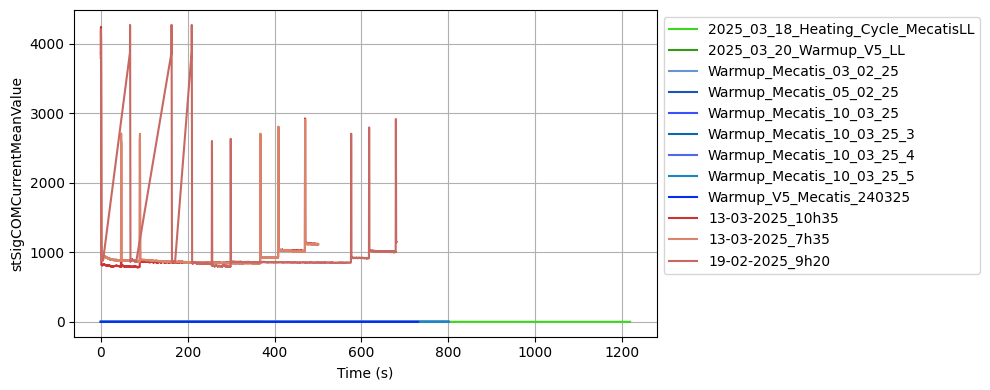

In [51]:


def plot_signal(data, signal_name, max_time_index, time_offset=0):
    plt.figure(figsize=(10, 4))
    for i in data :
        if signal_name in i["data"].columns :
            time = i["data"].loc[time_offset:max_time_index+time_offset, "timeSeconds"]
            signal = i["data"].loc[time_offset:max_time_index+time_offset, signal_name]
            plt.plot(time, signal, color = i["color"], label=i["warm_up_name"], markersize=3)
            plt.xlabel("Time (s)")
            plt.ylabel(signal_name)

    plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.grid()
    plt.show()

signal_name = "stSigCOMCurrentMeanValue"
max_time_index = 1000000

plot_signal(data_prepared, signal_name, max_time_index, time_offset=0)

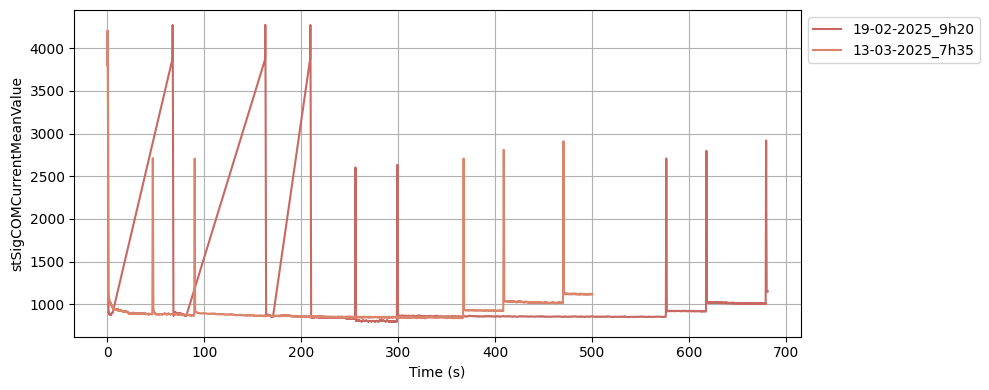

In [52]:
filtered_data = [data_prepared[-1]] + [data_prepared[-2]] 

plot_signal(filtered_data, "stSigCOMCurrentMeanValue", max_time_index, time_offset=0)

In [53]:
print(filtered_data[0]["data"].columns)

Index(['timeSeconds', 'stSigAxCurrentB', 'stSigAxCurrentC', 'stSigAxCurrentX',
       'stSigAxCurrentY', 'stSigAxCurrentZ', 'stSigAxFollErrB',
       'stSigAxFollErrC', 'stSigAxFollErrX', 'stSigAxFollErrY',
       'stSigAxFollErrZ', 'stSigAxPosACSB', 'stSigAxPosACSC', 'stSigAxPosACSX',
       'stSigAxPosACSY', 'stSigAxPosACSZ', 'stSigAxPosMCSB', 'stSigAxPosMCSC',
       'stSigAxPosMCSX', 'stSigAxPosMCSY', 'stSigAxPosMCSZ', 'stSigAxVeloACSB',
       'stSigAxVeloACSC', 'stSigAxVeloACSX', 'stSigAxVeloACSY',
       'stSigAxVeloACSZ', 'stSigAxVeloMCSB', 'stSigAxVeloMCSC',
       'stSigAxVeloMCSX', 'stSigAxVeloMCSY', 'stSigAxVeloMCSZ',
       'stSigCOMCurrentMeanValue', 'stSigCOMThresholdTrigger', 'stSigSinus',
       'stSigSpindleIndicator', 'stSigStatusULInt', 'stSigTouchPosACSB',
       'stSigTouchPosACSC', 'stSigTouchPosACSX', 'stSigTouchPosACSY',
       'stSigTouchPosACSZ', 'stSigTouchPosMCSB', 'stSigTouchPosMCSC',
       'stSigTouchPosMCSY', 'stSigTouchPosMCSZ', 'stSigOperation',
     

In [54]:
for ind in range(max_time_index) :
    time1 = filtered_data[0]["data"]["timeSeconds"][ind]
    time2 = filtered_data[1]["data"]["timeSeconds"][ind]

    if time1 != time2 :
        print(f"index, {ind}")
        print(time1)
        print(time2)
        
        break


index, 1154
0.5775
0.577


Time sampling sizes > 1 s


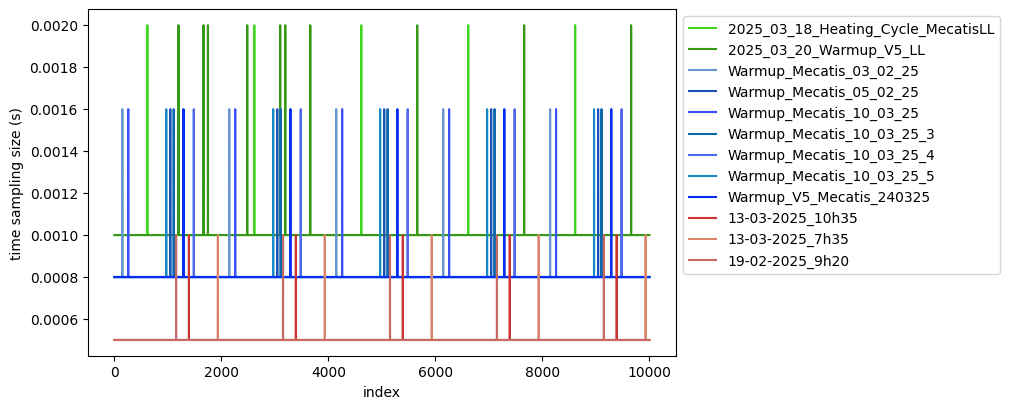

In [55]:
max_index = 10000

def plot_time_sampling(data_prepared, max_index) :
    plt.figure(figsize=(10, 4))
    max_time_samp = 1
    print(f"Time sampling sizes > {max_time_samp} s")

    for data in data_prepared :
        if max_index == "largest" :
            d_time = [data["data"]["timeSeconds"][i+1] - data["data"]["timeSeconds"][i] for i in range(len(data["data"]["timeSeconds"])-1)]
        else :
            d_time = [data["data"]["timeSeconds"][i+1] - data["data"]["timeSeconds"][i] for i in range(max_index)]
        plt.plot(d_time, color = data["color"], label = data["warm_up_name"])
        is_first = True

        for index, i in enumerate(d_time) :
            if i > max_time_samp :
                if is_first :
                    print(f"{data["warm_up_name"]} :")
                    is_first = False
                print(index)

    plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.xlabel("index")
    plt.ylabel("time sampling size (s)")
    plt.show()

plot_time_sampling(data_prepared, 10000)

In [56]:
plot_time_sampling(data_prepared, max_index="largest")

Time sampling sizes > 1 s


KeyboardInterrupt: 

<Figure size 1000x400 with 0 Axes>

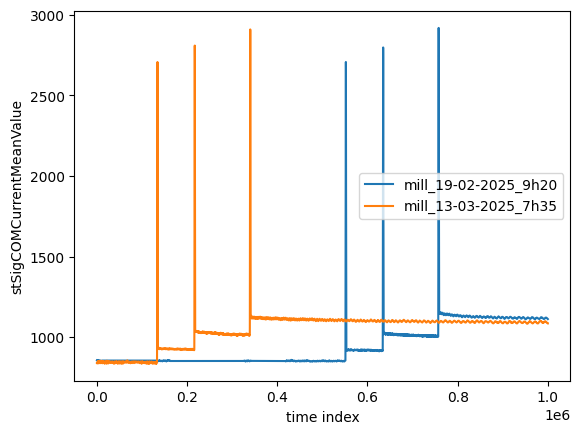

In [76]:
from scipy.interpolate import interp1d

#interpolate signals on the same time scale
max_time_index = 1000000
offset = 600000

signal1 = filtered_data[0]["data"].loc[offset:max_time_index+offset, "stSigCOMCurrentMeanValue"]
signal2 = filtered_data[1]["data"].loc[offset:max_time_index+offset, "stSigCOMCurrentMeanValue"]

label1 = "mill_" + filtered_data[0]["warm_up_name"]
label2 = "mill_" + filtered_data[1]["warm_up_name"]

t1 = filtered_data[0]["data"].loc[:max_time_index, "timeSeconds"]
t2 = filtered_data[1]["data"].loc[:max_time_index, "timeSeconds"]

def interpOnSameTimeScale(signal1, signal2, t1, t2, point_count=1000000):
    # create commun time scale
    t_common = np.linspace(max(t1.iloc[0], t2.iloc[0]), min(t1.iloc[-1], t2.iloc[-1]), point_count)

    # interpolate on t_common
    x_interp = interp1d(t1, signal1, kind='linear')(t_common)
    y_interp = interp1d(t2, signal2, kind='linear')(t_common)

    return x_interp, y_interp, t_common

x_interp, y_interp, _ = interpOnSameTimeScale(signal1, signal2, t1, t2)


plt.plot(x_interp, label=label1)
plt.plot(y_interp, label=label2)
plt.xlabel("time index")
plt.ylabel("stSigCOMCurrentMeanValue")
plt.legend()




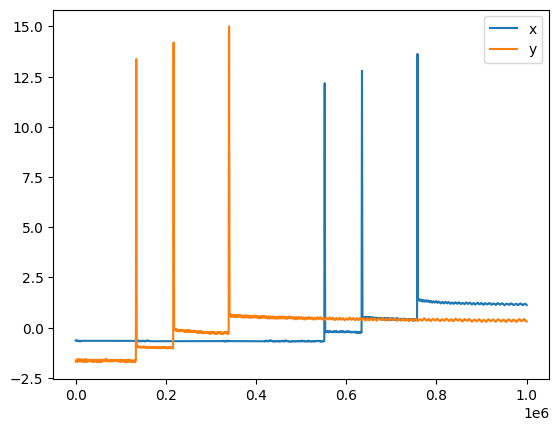

In [71]:
def normSignal(signal):
    signal_c = signal - np.mean(signal)
    signal_n = signal_c / np.std(signal_c)

    return signal_n

x_norm = normSignal(x_interp)
y_norm = normSignal(y_interp)

plt.plot(x_norm, label='x')
plt.plot(y_norm, label='y')
plt.legend()

In [72]:
from scipy.signal import correlate

def getLag(signal1_n, n_signal2_n):
    correlation = correlate(n_signal2_n, signal1_n, mode='full')
    lags = np.arange(-len(signal1_n) + 1, len(n_signal2_n))
    lag_max = lags[np.argmax(correlation)]

    return lag_max

lag = getLag(x_norm, y_norm)
print(lag)

-417834


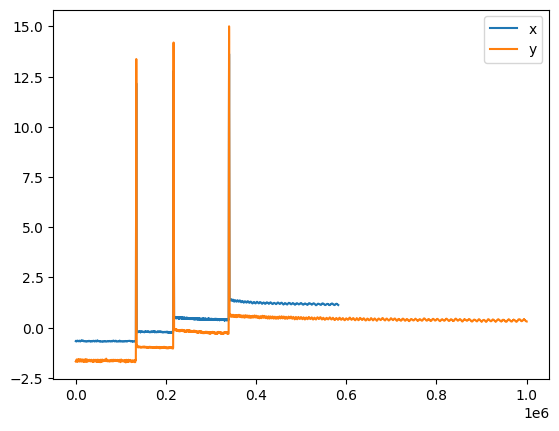

In [73]:

x_lag = x_norm[np.abs(lag):]
y_lag = y_norm

plt.plot(x_lag, label='x')
plt.plot(y_lag, label='y')
plt.legend()

Mean error before : 0.7573126413473581
Mean error after : 0.10711496160383951


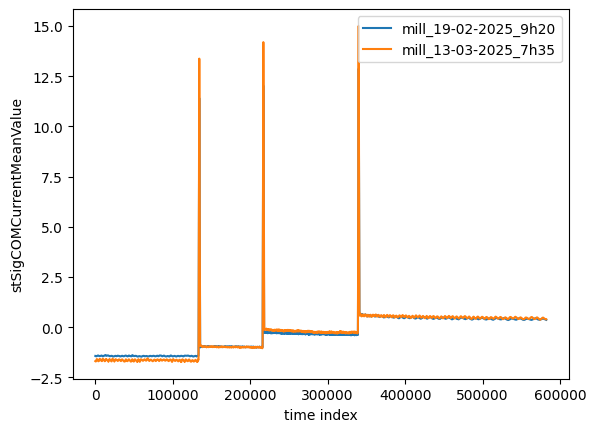

In [77]:
y_aligned = y_lag[:x_lag.shape[0]]

delta_before = np.mean(x_lag - y_aligned)

x_aligned = x_lag-delta_before

delta_after = np.mean(np.abs(x_aligned - y_aligned))

plt.plot(x_aligned, label=label1)
plt.plot(y_aligned, label=label2)

plt.xlabel("time index")
plt.ylabel("stSigCOMCurrentMeanValue")
plt.legend()


print(f"Mean error before : {delta_before}")
print(f"Mean error after : {delta_after}")

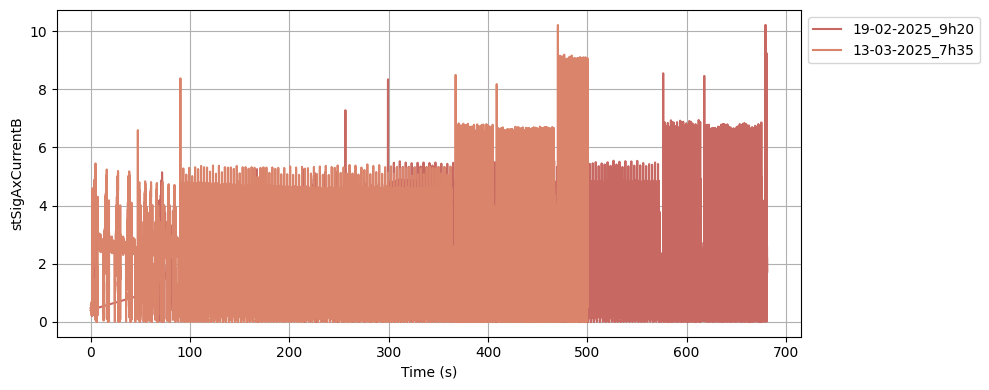

In [19]:
plot_signal(filtered_data, "stSigAxCurrentB", max_time_index, time_offset=0)


Text(0.5, 1.0, 'Signals on same sampling interval')

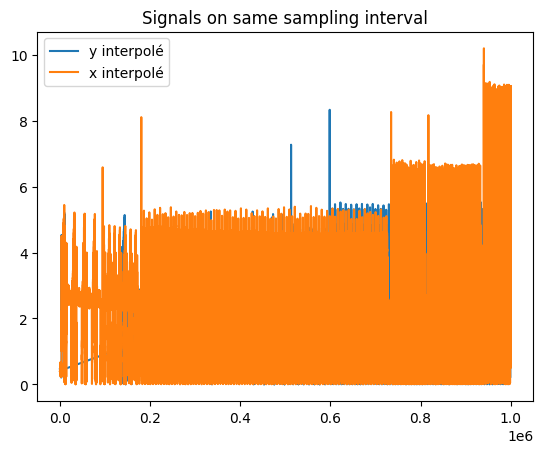

In [20]:
max_time_index = 1000000
offset = 0

signal1 = filtered_data[0]["data"].loc[offset:max_time_index+offset, "stSigAxCurrentB"]
signal2 = filtered_data[1]["data"].loc[offset:max_time_index+offset, "stSigAxCurrentB"]



t1 = filtered_data[0]["data"].loc[:max_time_index, "timeSeconds"]
t2 = filtered_data[1]["data"].loc[:max_time_index, "timeSeconds"]

x_interp, y_interp, _ = interpOnSameTimeScale(signal1, signal2, t1, t2)

plt.plot(x_interp, label='y interpolé')
plt.plot(y_interp, label='x interpolé')

plt.legend()
plt.title("Signals on same sampling interval")



In [21]:
print(lag)

-417834


Mean error before : 0.2889115212899354
Mean error after : 0.18433548070320402


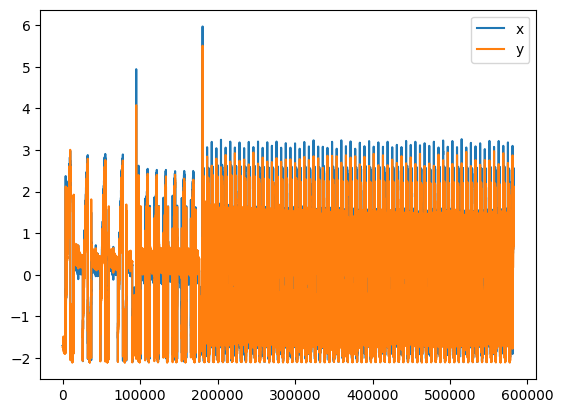

In [22]:
x_norm = normSignal(x_interp)
y_norm = normSignal(y_interp)

x_lag = x_norm[np.abs(lag):]
y_lag = y_norm

y_aligned = y_lag[:x_lag.shape[0]]

delta_before = np.mean(x_lag - y_aligned)

x_aligned = x_lag-delta_before

delta_after = np.mean(np.abs(x_aligned - y_aligned))

plt.plot(x_aligned, label='x')
plt.plot(y_aligned, label='y')
plt.legend()

print(f"Mean error before : {delta_before}")
print(f"Mean error after : {delta_after}")

In [23]:
print(signal1)
print(signal2)

0          0.479488
1          0.479488
2          0.482301
3          0.482301
4          0.483474
             ...   
999996     1.857417
999997     1.857417
999998     2.011663
999999     2.011663
1000000    1.826734
Name: stSigAxCurrentB, Length: 1000001, dtype: float64
0          0.401429
1          0.402414
2          0.402414
3          0.402348
4          0.402348
             ...   
999996     4.090202
999997     3.860530
999998     2.752898
999999     2.752898
1000000    1.807377
Name: stSigAxCurrentB, Length: 1000001, dtype: float64


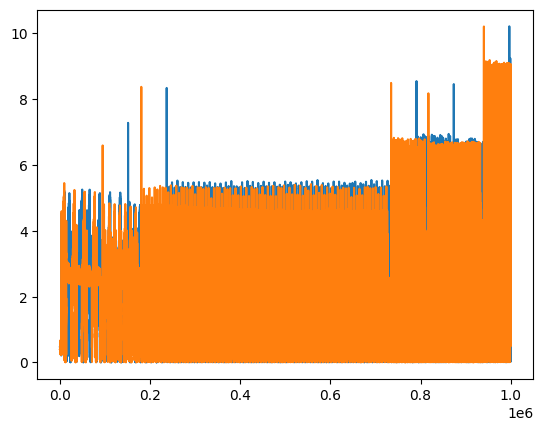

In [24]:
plt.plot(signal1)
plt.plot(signal2)
plt.show()

In [25]:
Mecatis_data = [d for d in data_prepared if d.get("machine_name") == "Mecatis"]

print(Mecatis_data)

[{'machine_name': 'Mecatis', 'warm_up_name': 'Warmup_Mecatis_03_02_25', 'warm_up_type': 'parquet', 'warm_up_path': 'c:\\Users\\Antoine\\Documents\\master\\PI\\predictiveMaintenance-main\\data\\prepared\\Mecatis\\Warmup_Mecatis_03_02_25.parquet', 'data':          timeSeconds  stSigAxCurrentB  diCodeMesure  lrSigAxeBTemp  \
0             0.0000           0.1531           0.0           10.0   
1             0.0008           0.1564           0.0           10.0   
2             0.0016           0.1569           0.0           10.0   
3             0.0024           0.1561           0.0           10.0   
4             0.0032           0.1449           0.0           10.0   
...              ...              ...           ...            ...   
2065385    1653.1392           0.3711           0.0           10.0   
2065386    1653.1400           0.3711           0.0           10.0   
2065387    1653.1408           0.3891           0.0           10.0   
2065388    1653.1416           0.4485         

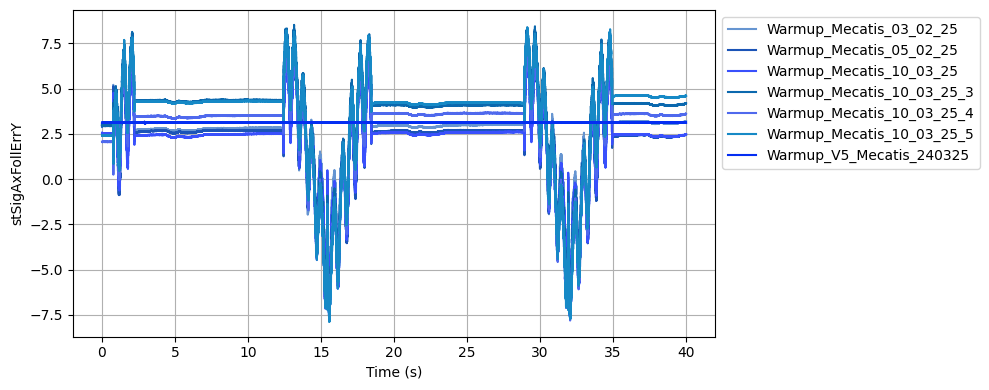

In [26]:
signal_name = "stSigAxFollErrY"
max_time_index = 50000

plot_signal(Mecatis_data, signal_name, max_time_index, time_offset=0)

In [27]:
def filter_strong_variations(a, x=3, threshold=10):
    a = np.array(a)
    valid_indices = []

    for i in range(len(a)):
        start = max(0, i - x)
        end = min(len(a), i + x + 1)
        
        neighbors = np.delete(a[start:end], i - start)

        if len(neighbors) == 0:
            continue

        mean_neighbors = np.mean(neighbors)
        if abs(a[i] - mean_neighbors) <= threshold:
            valid_indices.append(i)

    return a[valid_indices]

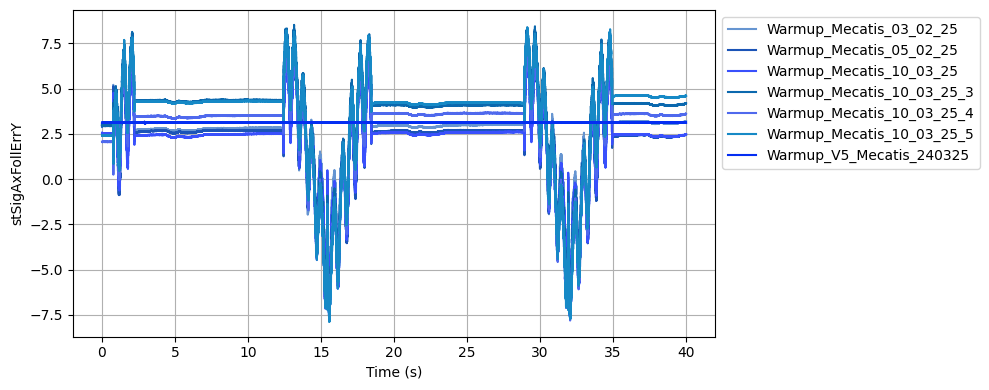

adjusted V1


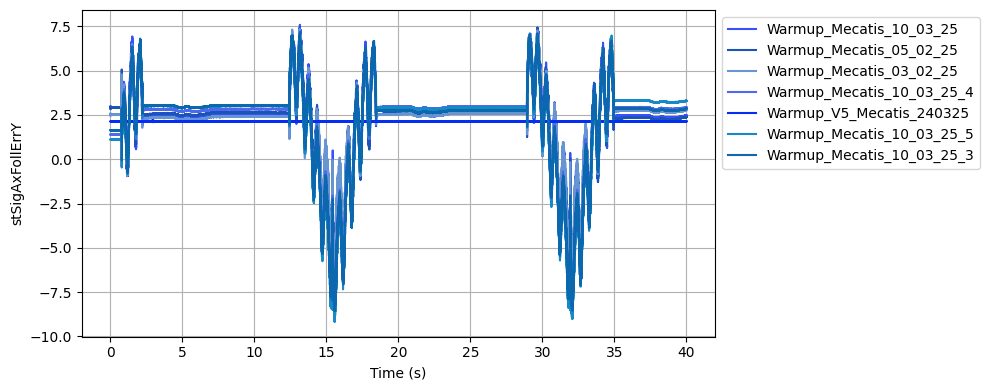

adjusted V2


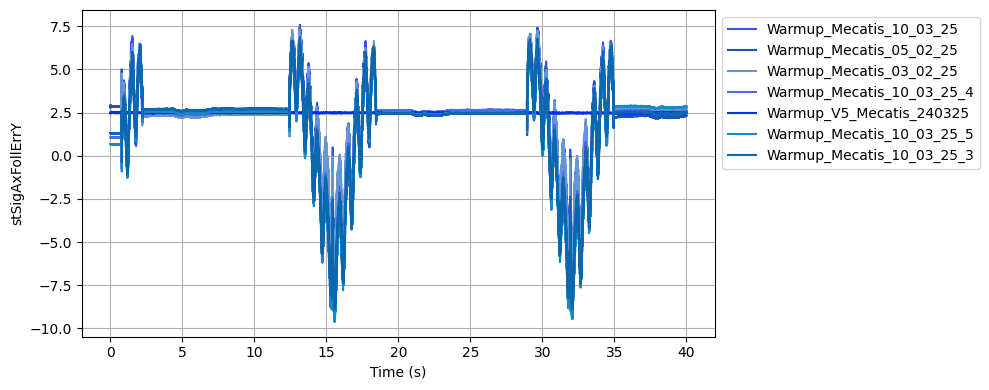

In [28]:
import copy
# retrieve signal data on a specific index range
def get_sampled_signal(data, signal_name, max_time_index, time_offset=0):
    sample_signal = []
    for i in data :
        temp_dict = {}
        if signal_name in i["data"].columns :
            temp_dict["time"] = i["data"].loc[time_offset:max_time_index+time_offset, "timeSeconds"]
            temp_dict["signal"] = i["data"].loc[time_offset:max_time_index+time_offset, signal_name]
            temp_dict["mean"] = np.mean(temp_dict["signal"])
            temp_dict["color"] = i["color"]
            temp_dict["label"] = i["warm_up_name"]
        
        sample_signal.append(temp_dict)

    return sample_signal

# adjuste signals with the first one as reference
def y_adjust_sample_signal(sample_signal) :
    for i in range(1, len(sample_signal)):
        delta_y = sample_signal[i]["mean"]-sample_signal[0]["mean"]
        sample_signal[i]["signal"] = sample_signal[i]["signal"]-delta_y
    
    return sample_signal

# adjuste signals with the first one as reference, by tacking stationary phase means
def y_adjust_sample_signal_2(sample_signal) :
    for i in range(1, len(sample_signal)):
        x = 100
        threshold =0.01

        mean_i = np.mean(filter_strong_variations(sample_signal[i]["signal"], x=x, threshold=threshold))
        mean_0 = np.mean(filter_strong_variations(sample_signal[0]["signal"], x=x, threshold=threshold))

        delta_y = mean_i-mean_0
        sample_signal[i]["signal"] = sample_signal[i]["signal"]-delta_y
    
    return sample_signal


signal_name = "stSigAxFollErrY"
max_time_index = 50000

sample_signal = get_sampled_signal(Mecatis_data, signal_name, max_time_index, time_offset=0)
#take lowest signal as reference
sample_signal = sorted(sample_signal, key=lambda d: d["mean"])


sample_signal_1 = y_adjust_sample_signal(sample_signal.copy())
sample_signal_2 = y_adjust_sample_signal_2(copy.deepcopy(sample_signal))

#before y offset adjusted
plot_signal(Mecatis_data, signal_name, max_time_index, time_offset=0)

#after y offset adjusted
def plot_sampled_signal(sample_signal, signal_name) :
    plt.figure(figsize=(10, 4))
    for i in range(len(sample_signal)) :
        
        plt.plot(sample_signal[i]["time"], sample_signal[i]["signal"], color = sample_signal[i]["color"], label = sample_signal[i]["label"])
        

    plt.xlabel("Time (s)")
    plt.ylabel(signal_name)
    plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.grid()
    plt.show()

print("adjusted V1")
plot_sampled_signal(sample_signal_1, signal_name)
print("adjusted V2")
plot_sampled_signal(sample_signal_2, signal_name)

In [29]:
index = 2
signals = data_prepared[2]["data"].columns

print(data_prepared[index]["warm_up_name"])
print(signals)

Warmup_Mecatis_03_02_25
Index(['timeSeconds', 'stSigAxCurrentB', 'diCodeMesure', 'lrSigAxeBTemp',
       'lrSigAxeCTemp', 'lrSigAxeXTemp', 'lrSigAxeYTemp', 'lrSigAxeZTemp',
       'lrSigCryoLubState', 'lrSigFeedRateOverride', 'lrSigLubrificationState',
       'lrSigMeasurementMode', 'lrSigPieceTemp', 'lrSigSpindleOverride',
       'lrSigSpindleTemp', 'lrSigTableTemp', 'lrSigZoneAxeTemp',
       'm70DataDouble', 'process', 'stSigAxCurrentC', 'stSigAxCurrentS',
       'stSigAxCurrentX', 'stSigAxCurrentY', 'stSigAxCurrentZ',
       'stSigAxFollErrB', 'stSigAxFollErrC', 'stSigAxFollErrX',
       'stSigAxFollErrY', 'stSigAxFollErrZ', 'stSigAxPosACSB',
       'stSigAxPosACSC', 'stSigAxPosACSX', 'stSigAxPosACSY', 'stSigAxPosACSZ',
       'stSigAxPosMCSB', 'stSigAxPosMCSC', 'stSigAxPosMCSX', 'stSigAxPosMCSY',
       'stSigAxPosMCSZ', 'stSigAxVeloACSB', 'stSigAxVeloACSC',
       'stSigAxVeloACSX', 'stSigAxVeloACSY', 'stSigAxVeloACSZ',
       'stSigAxVeloMCSB', 'stSigAxVeloMCSC', 'stSigAxVeloMCS

In [30]:
print(data_prepared[1]["warm_up_name"])
print(data_prepared[8]["warm_up_name"])

2025_03_20_Warmup_V5_LL
Warmup_V5_Mecatis_240325


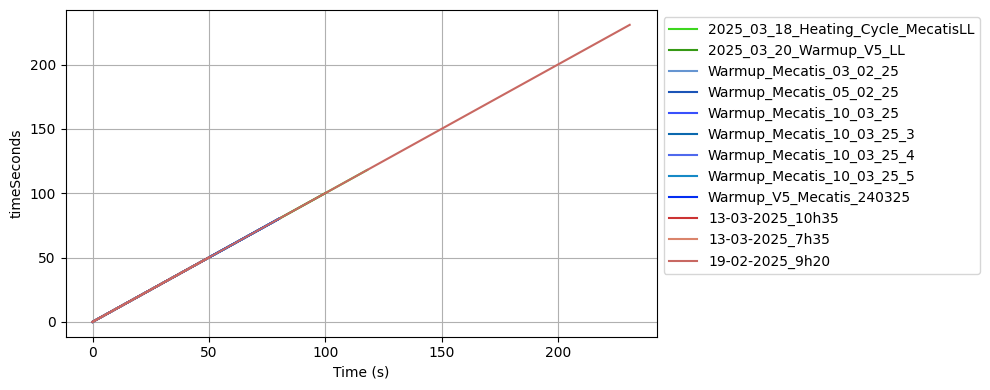

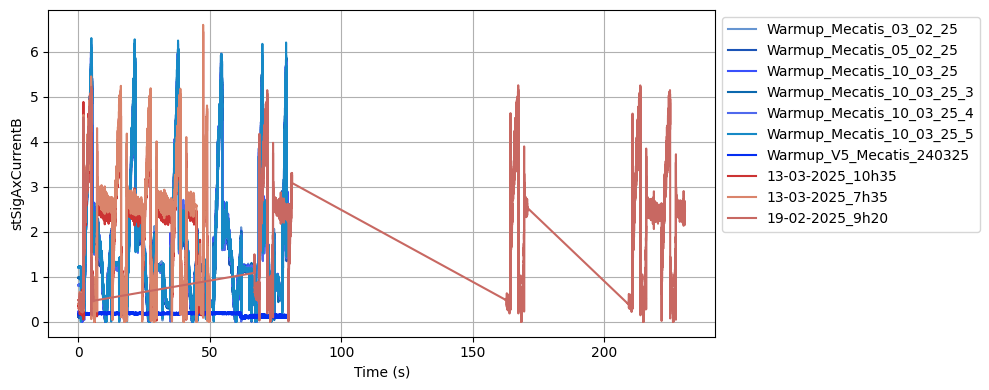

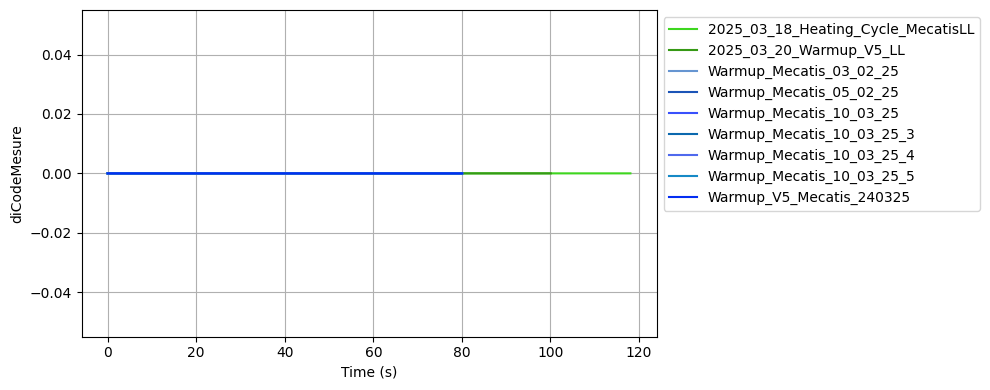

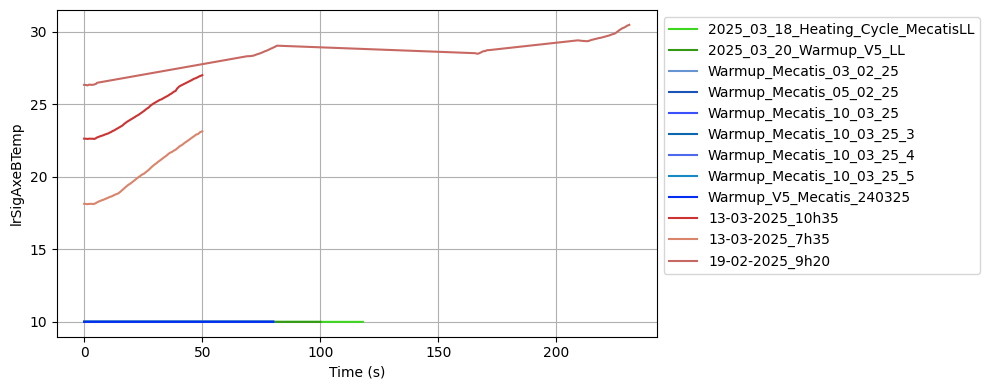

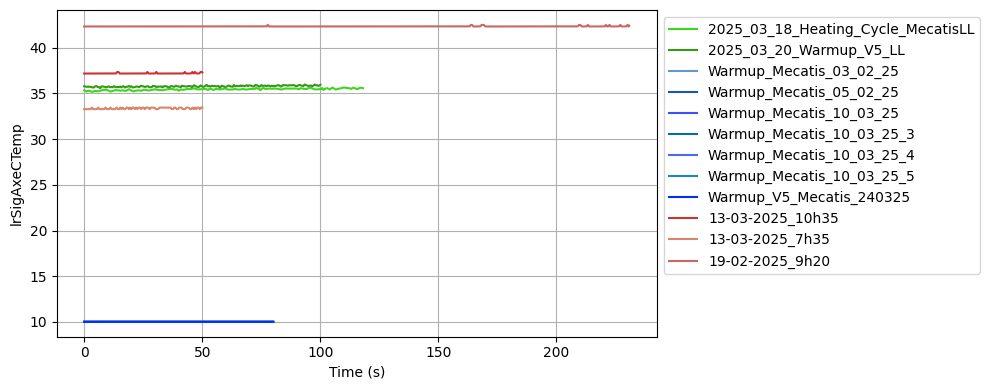

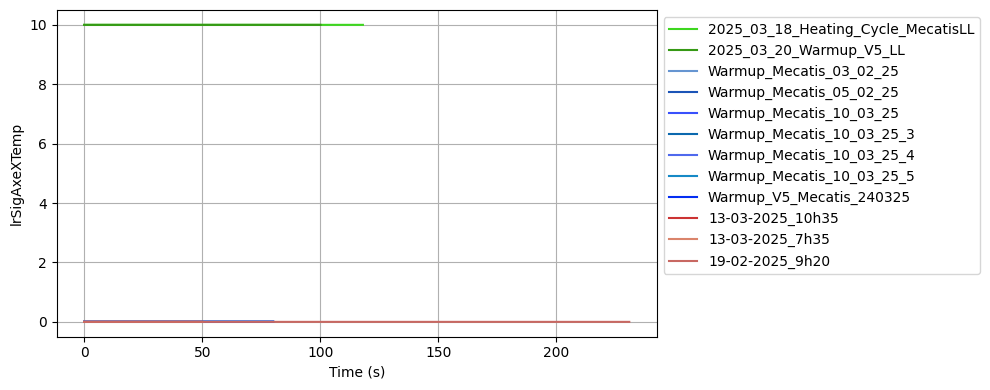

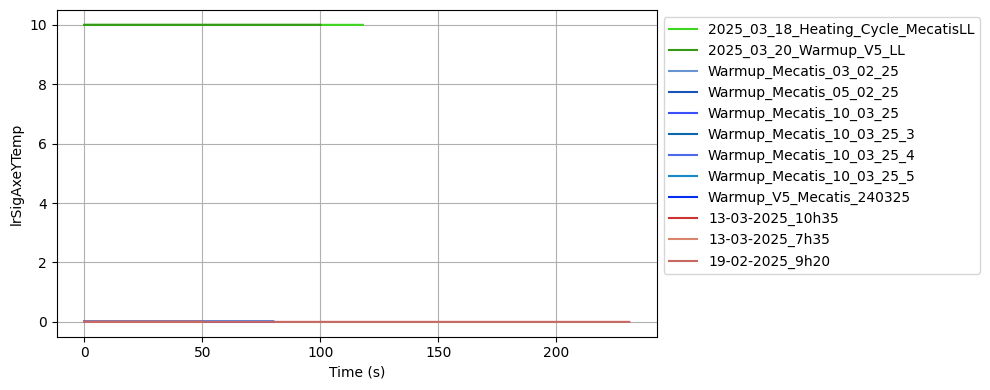

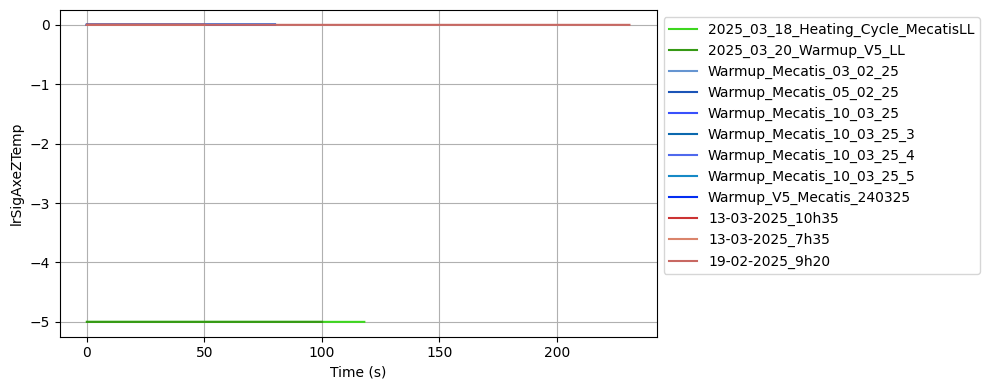

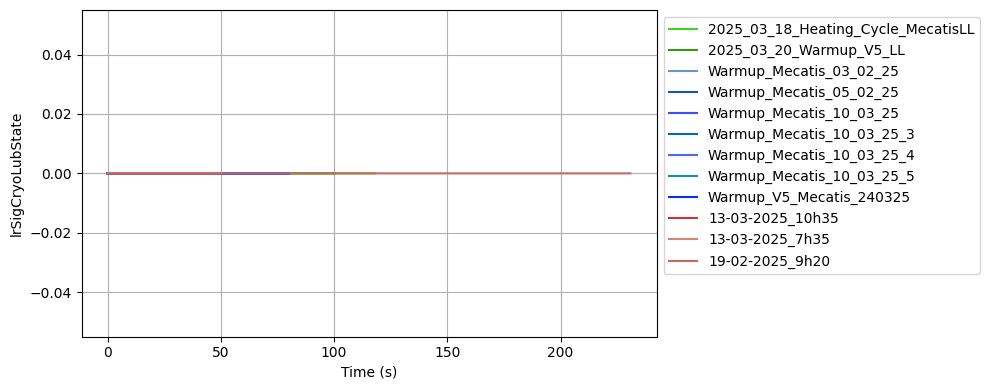

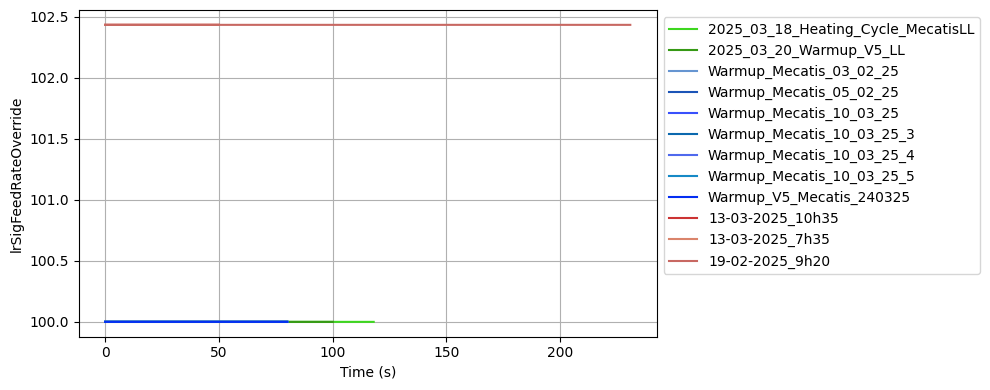

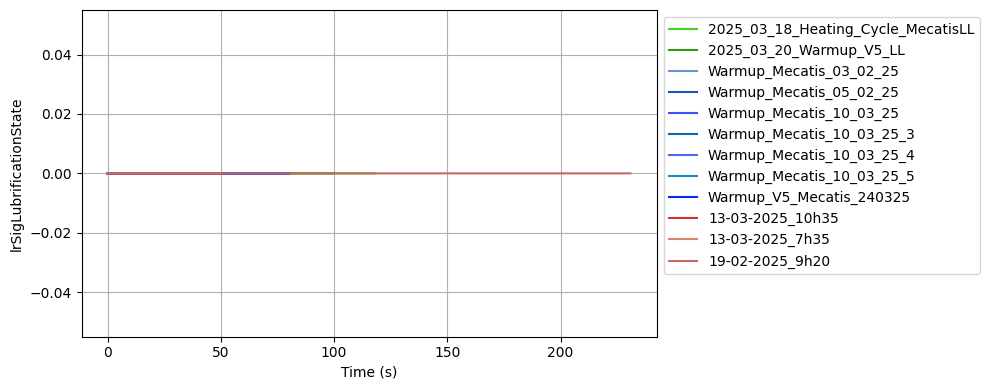

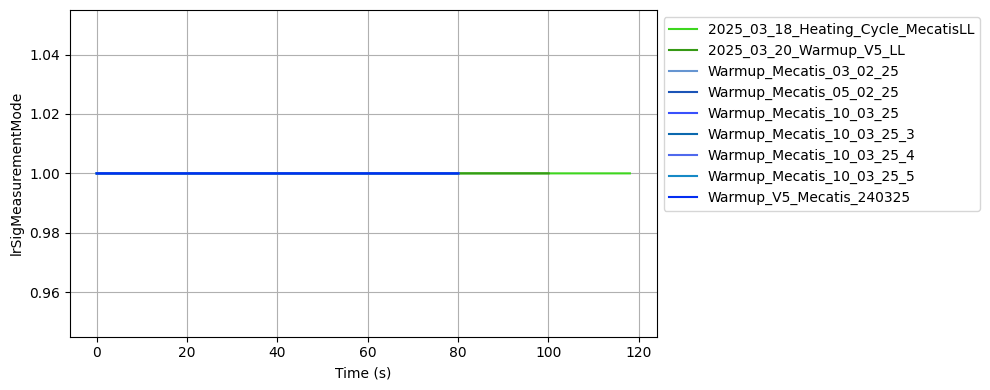

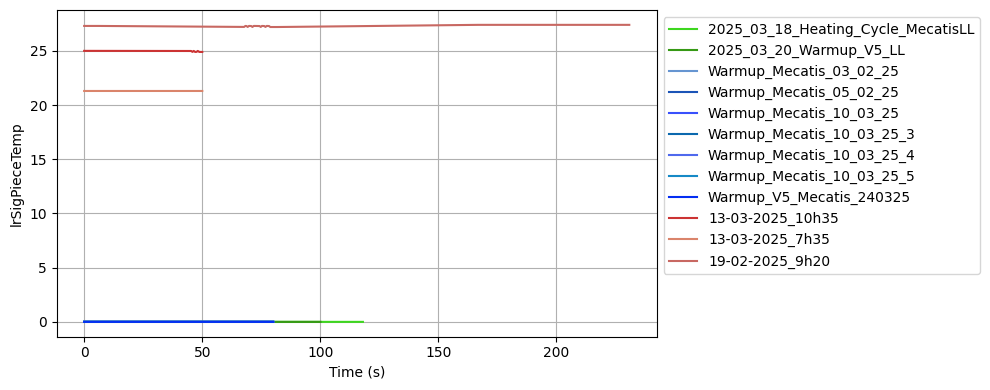

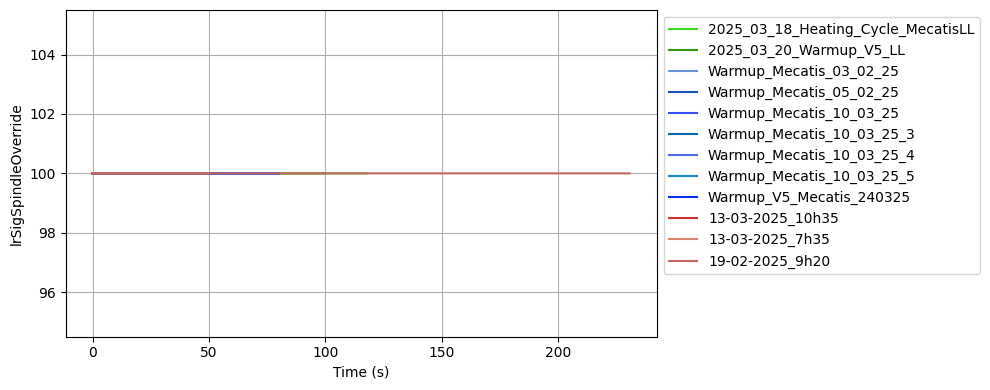

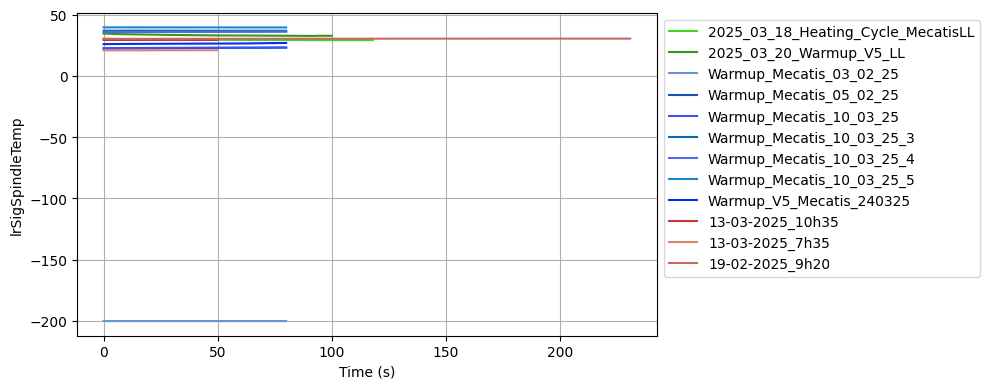

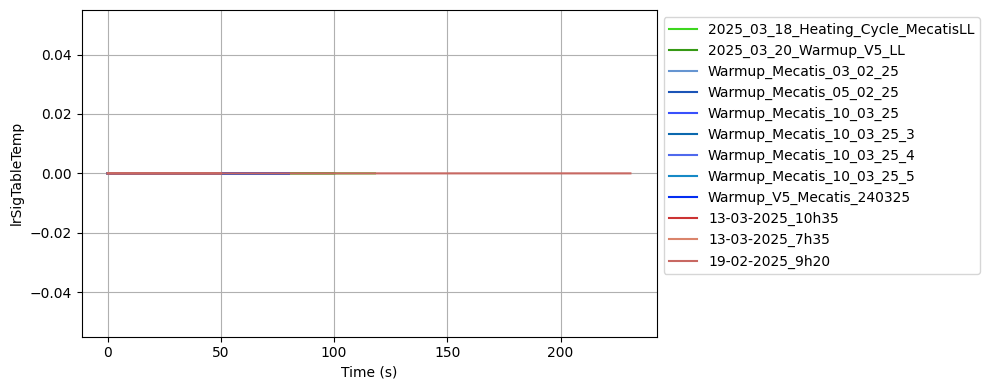

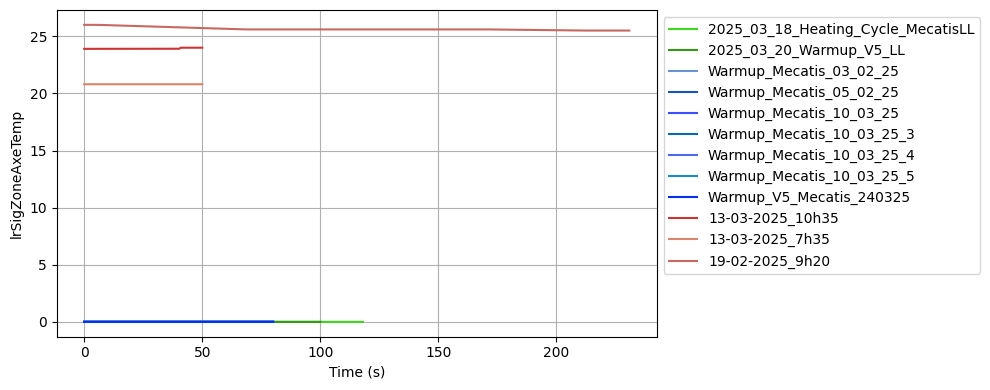

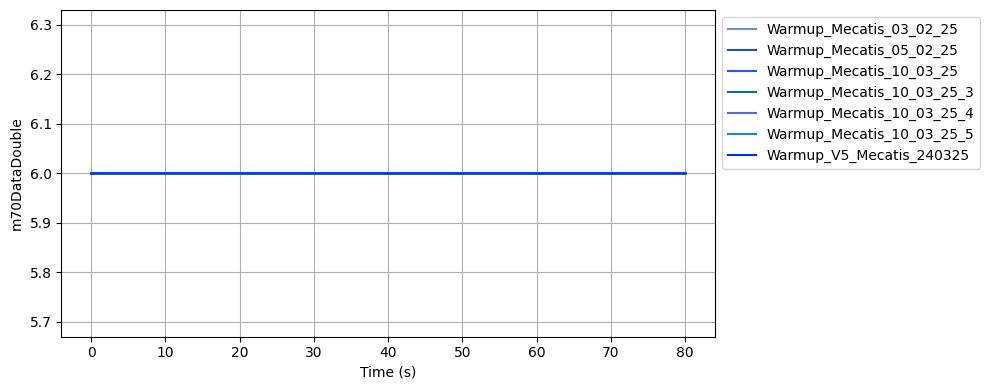

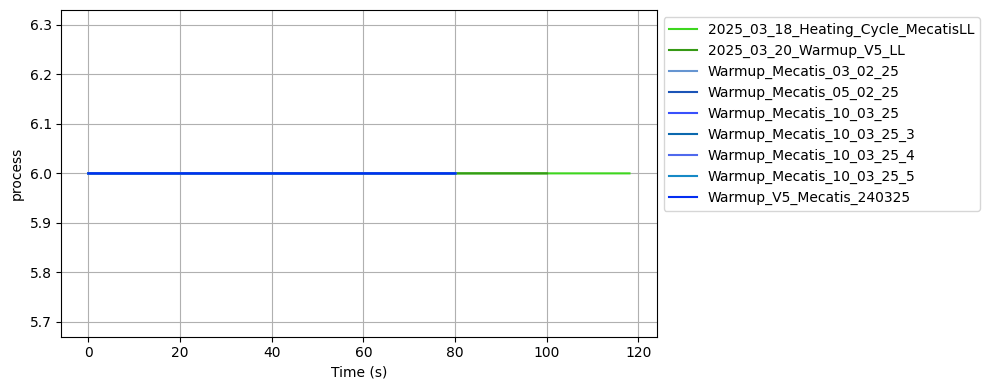

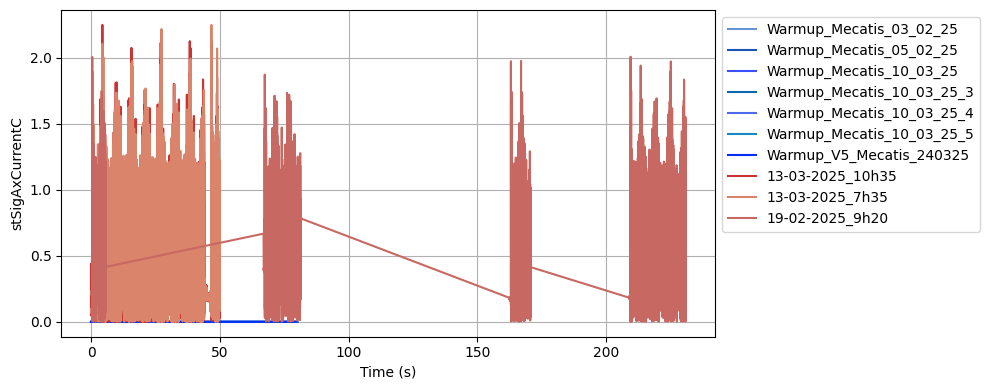

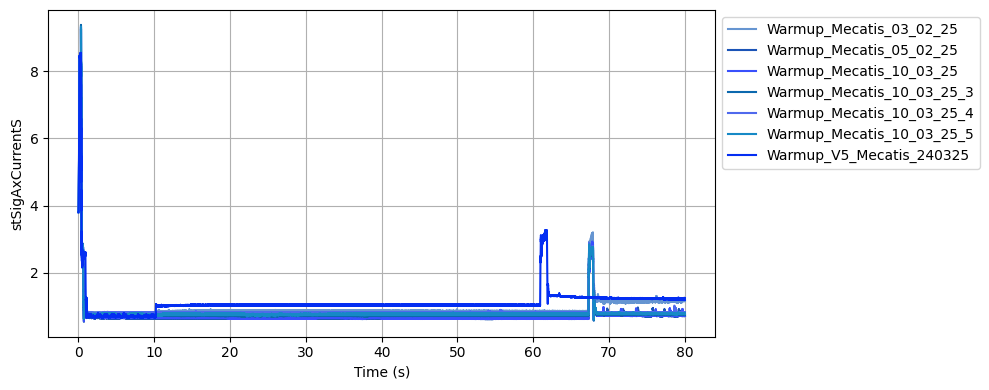

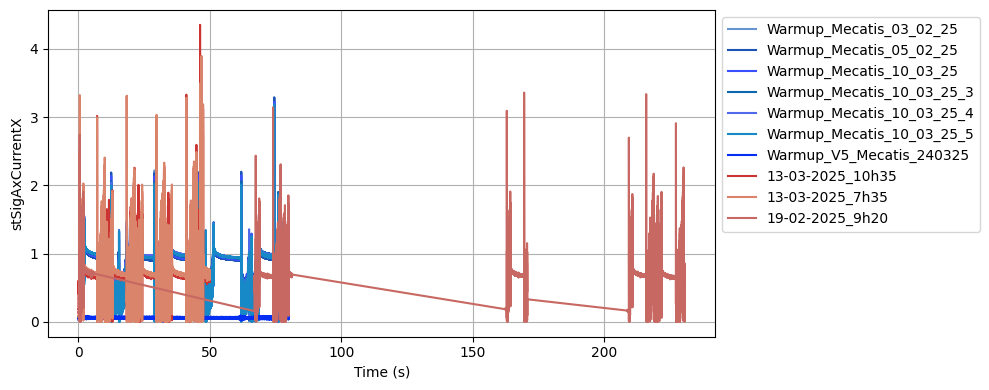

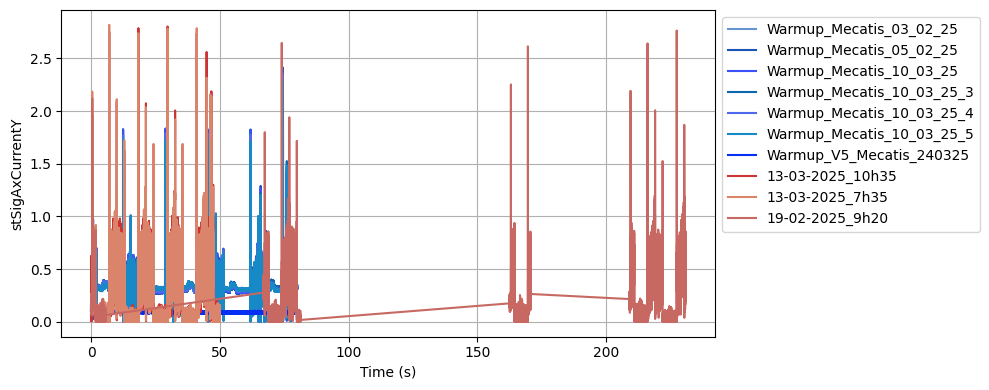

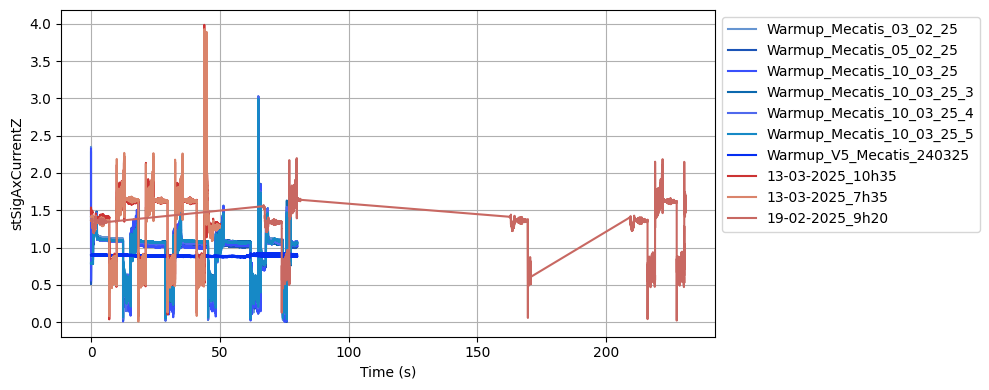

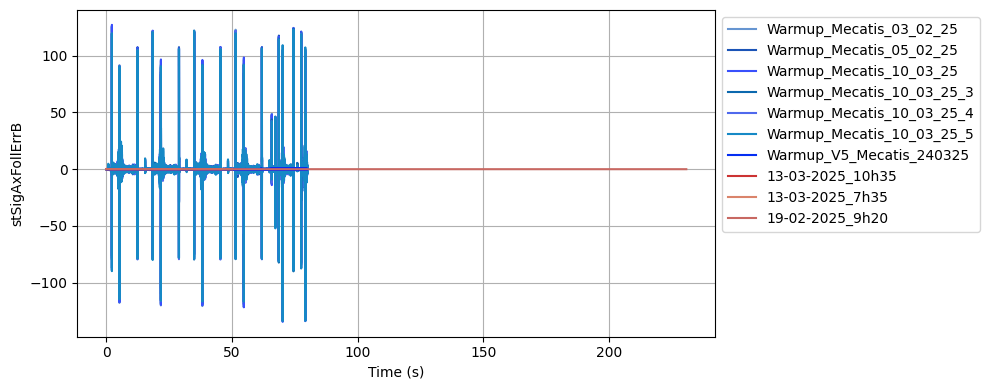

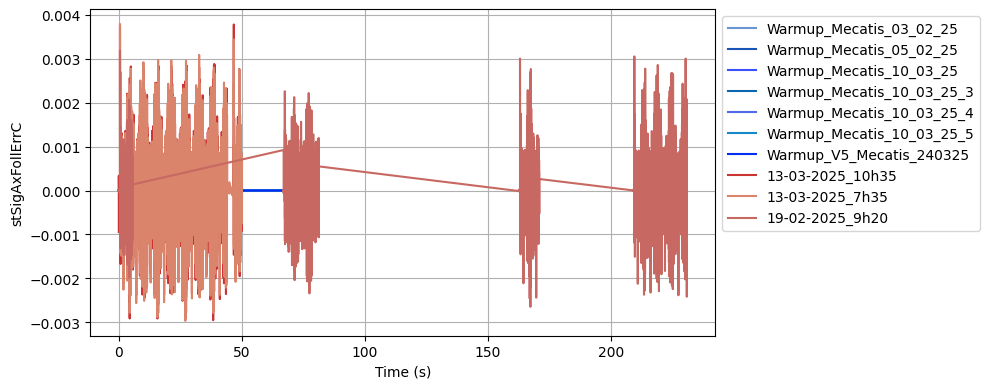

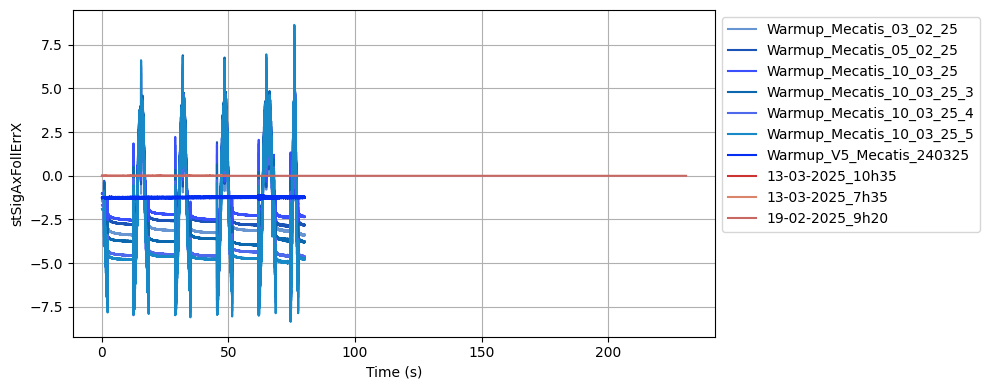

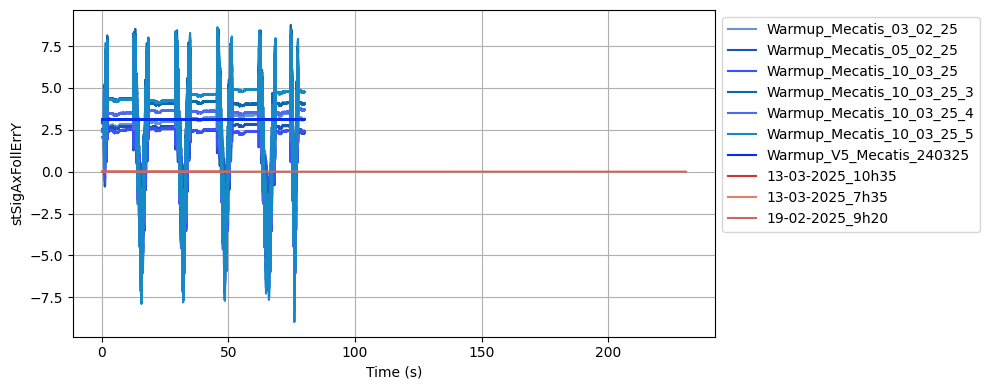

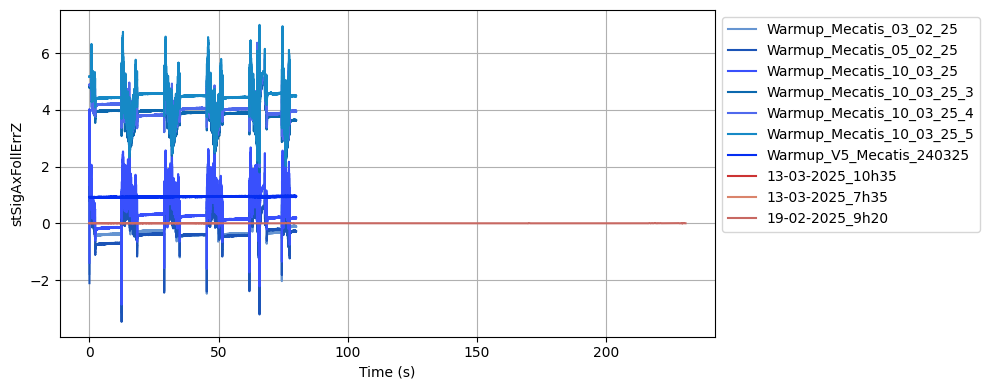

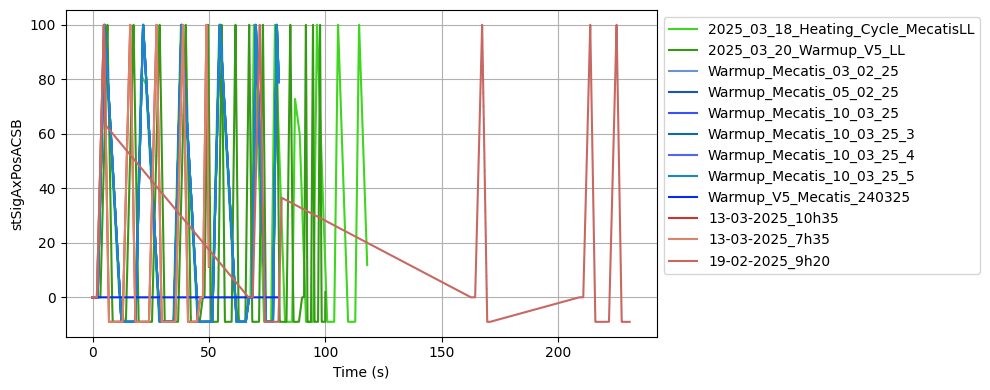

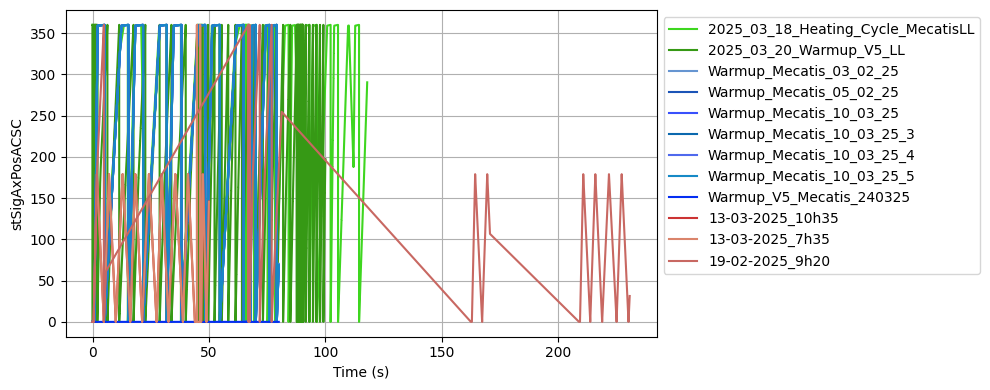

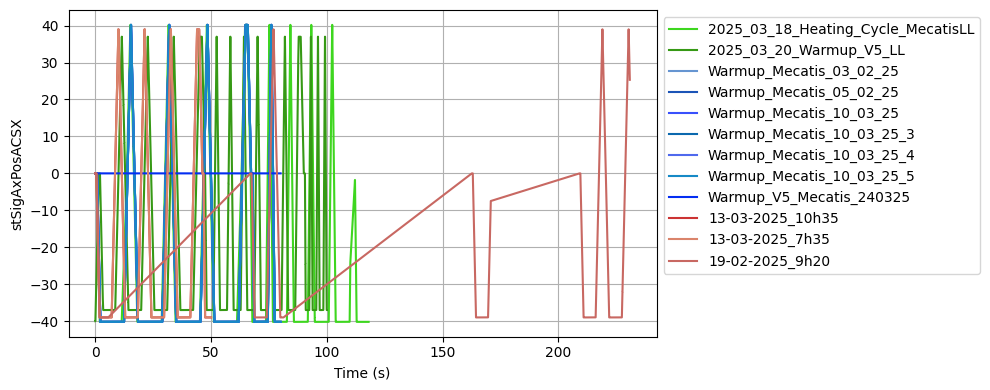

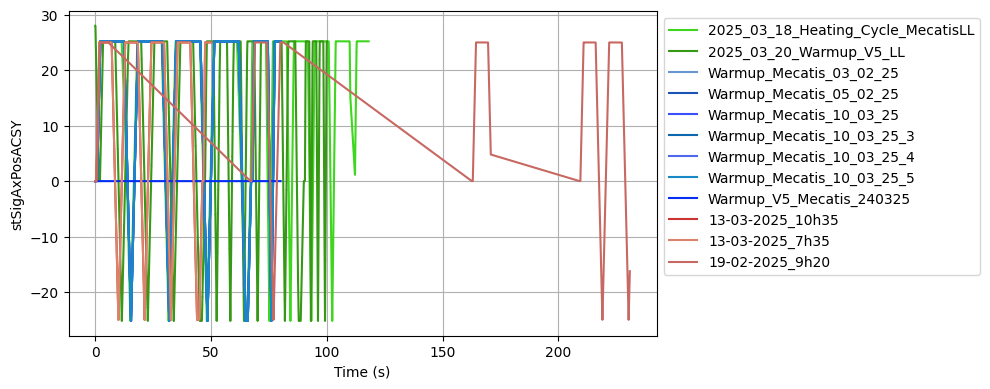

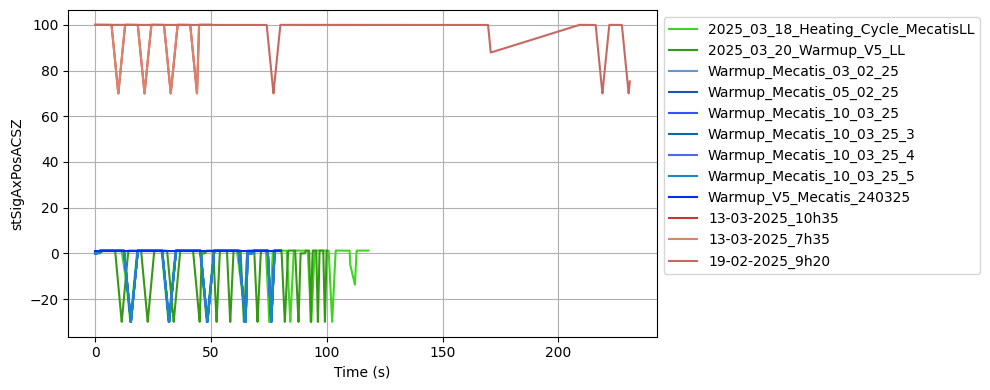

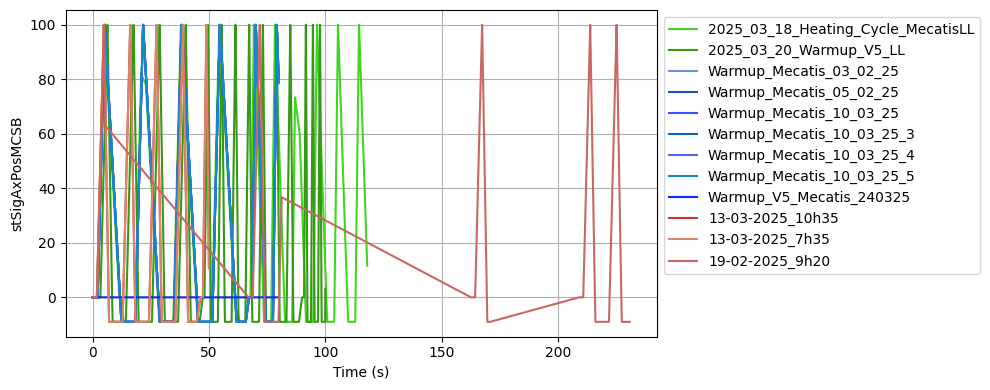

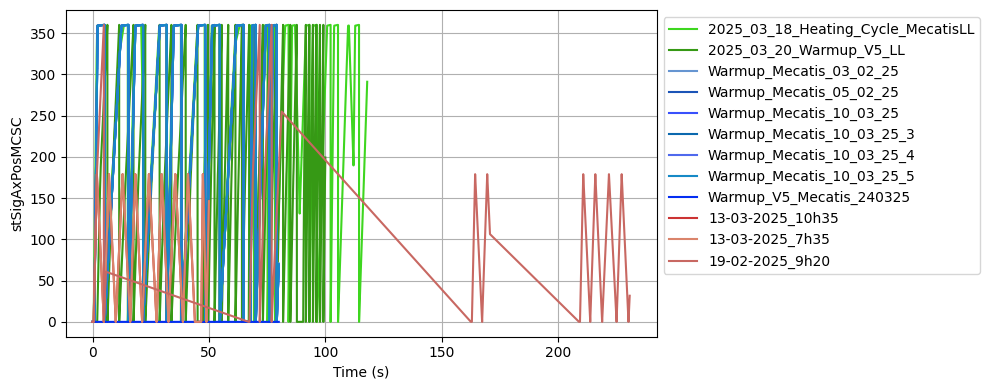

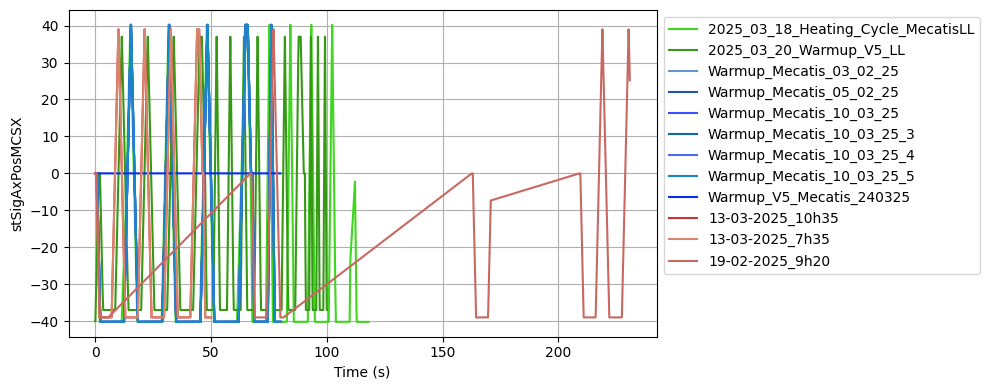

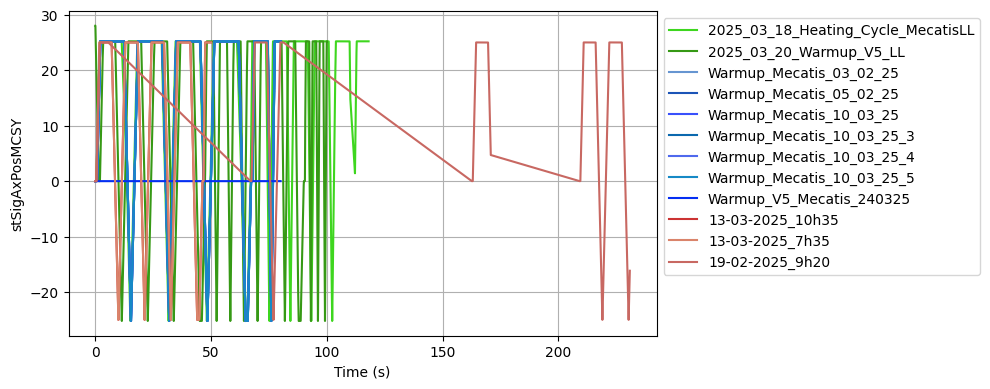

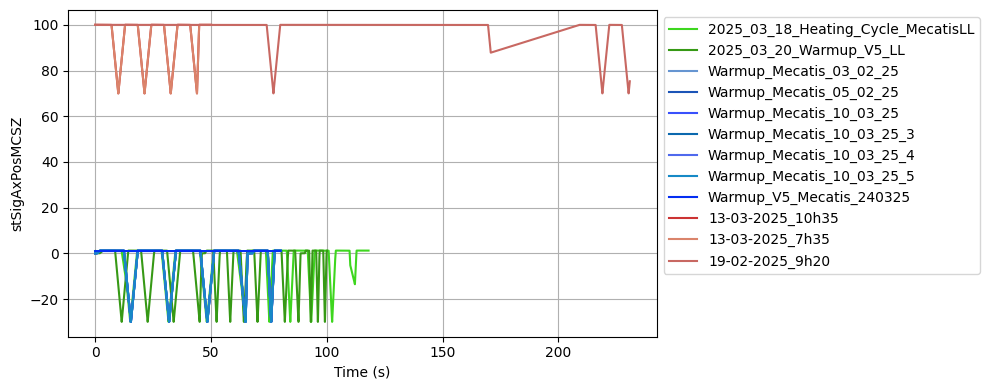

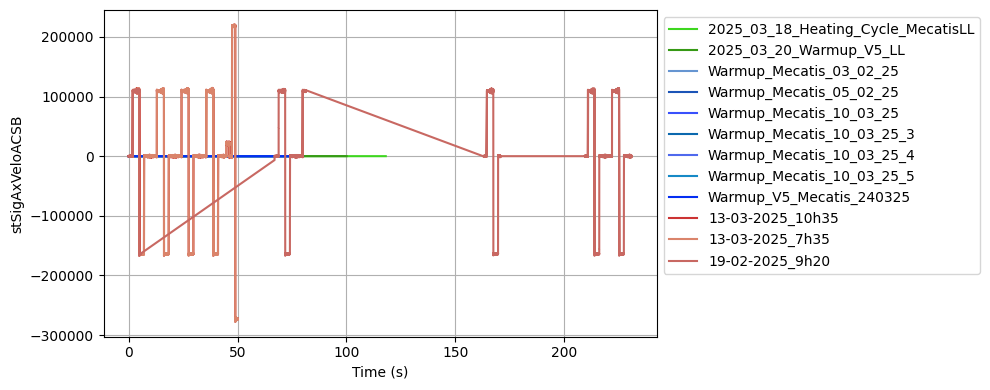

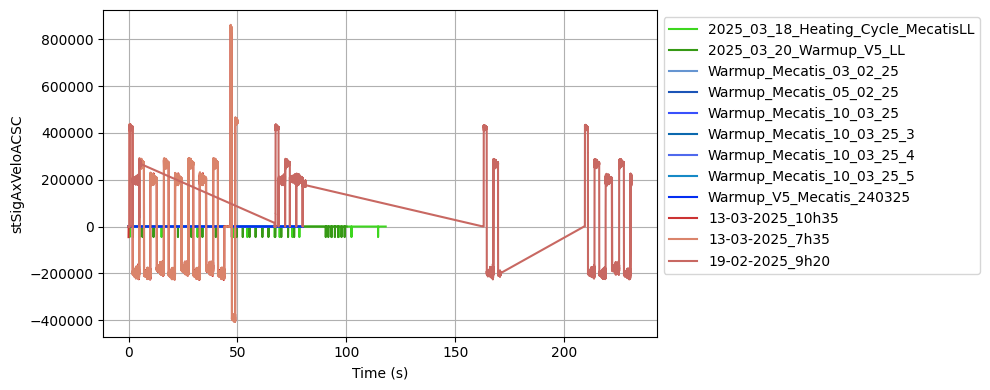

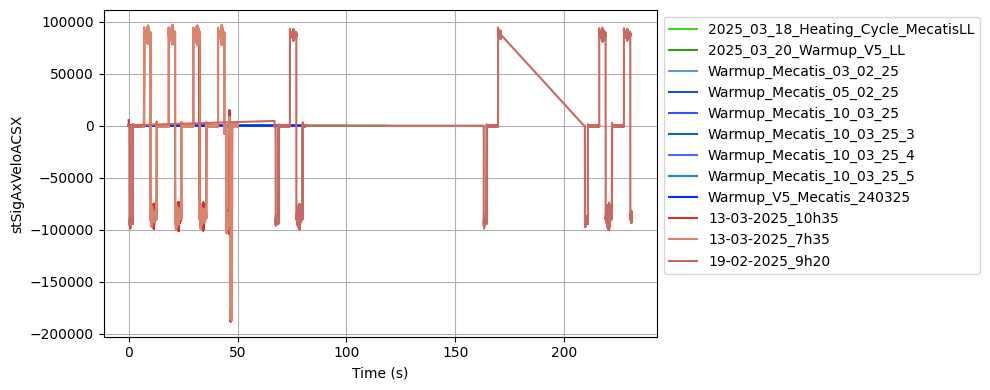

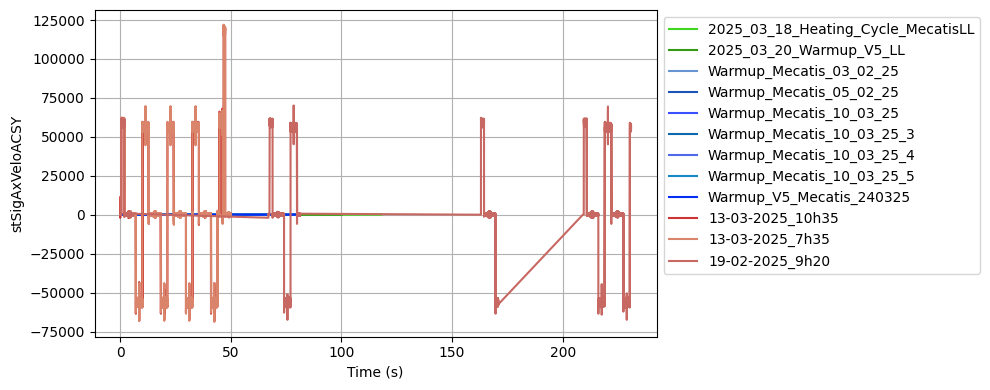

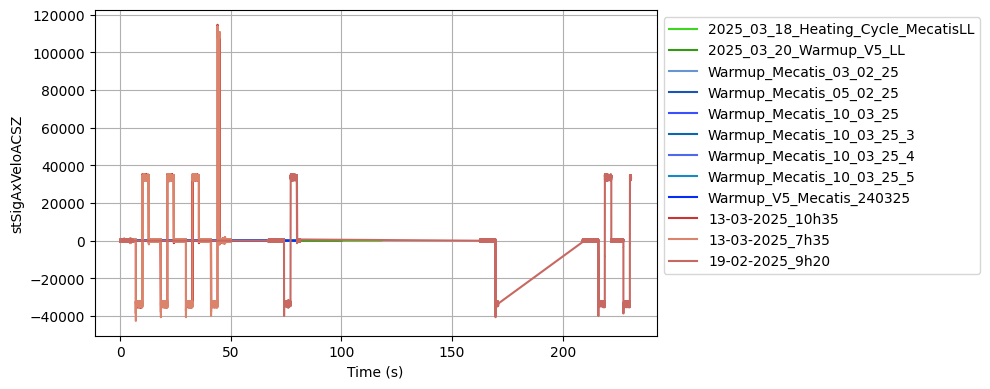

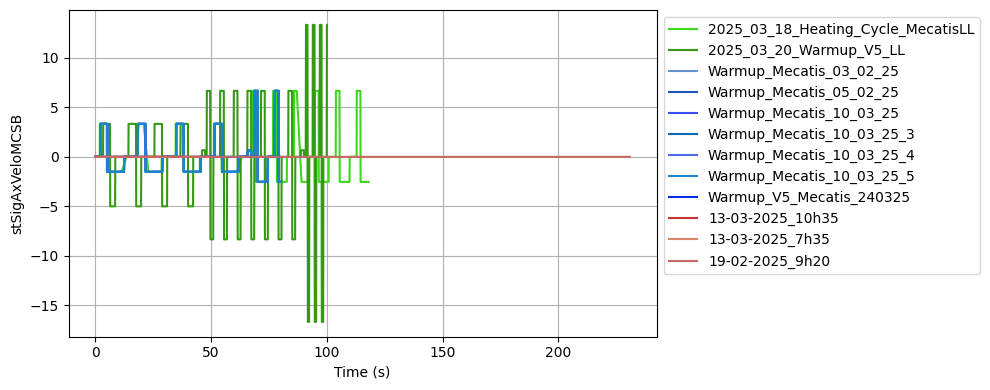

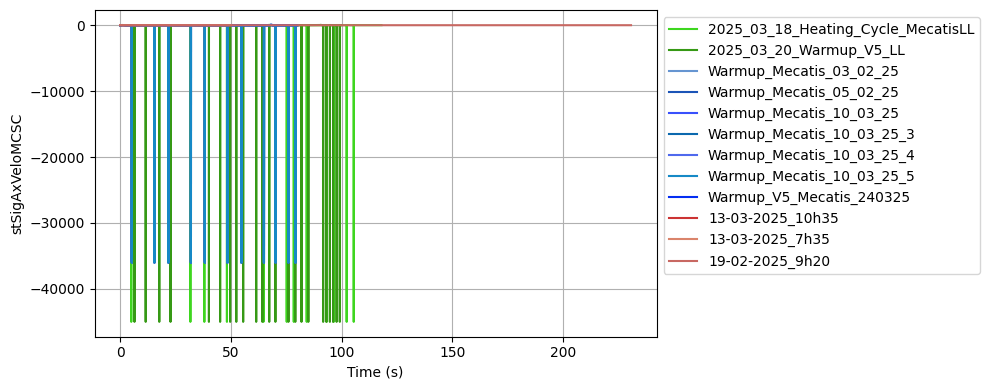

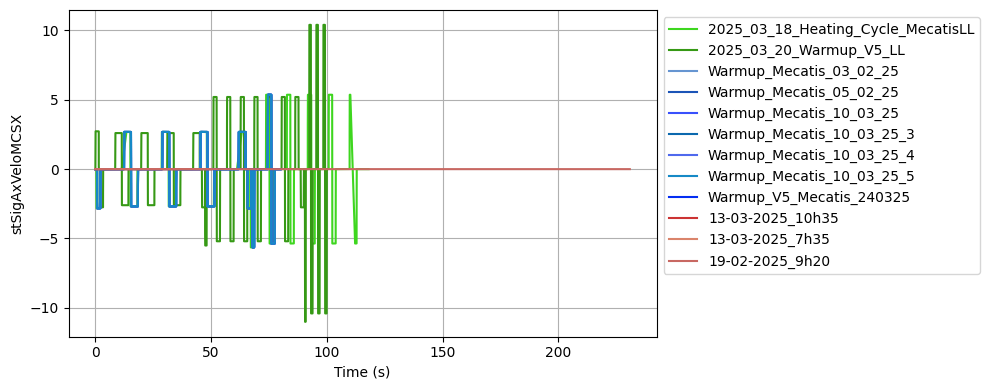

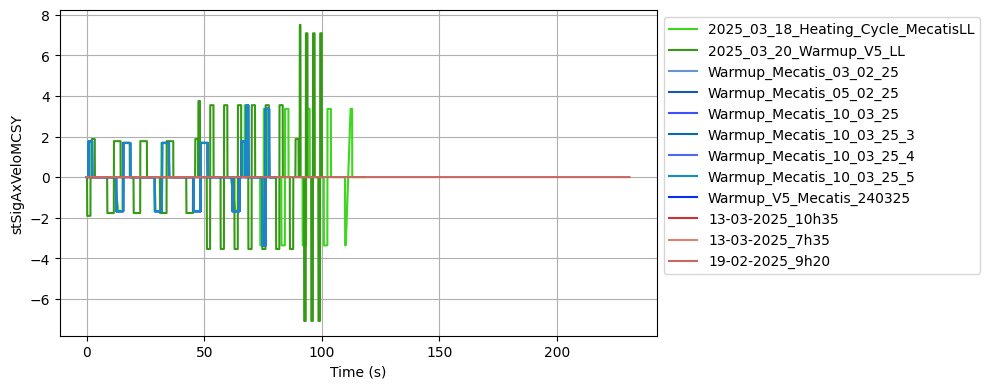

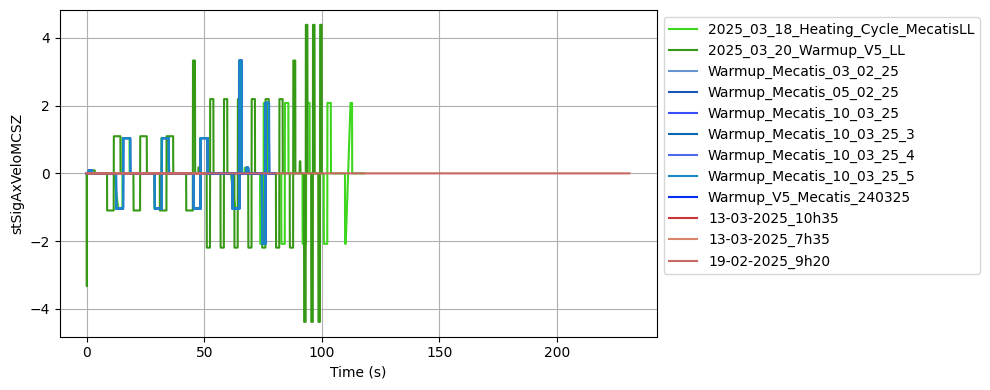

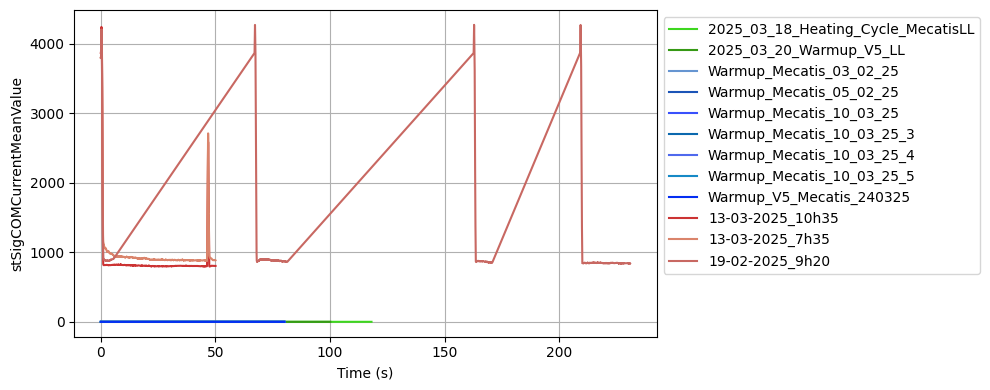

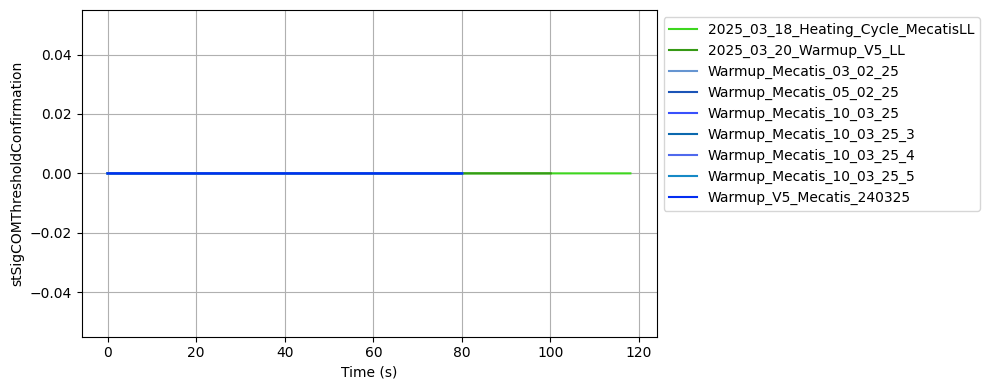

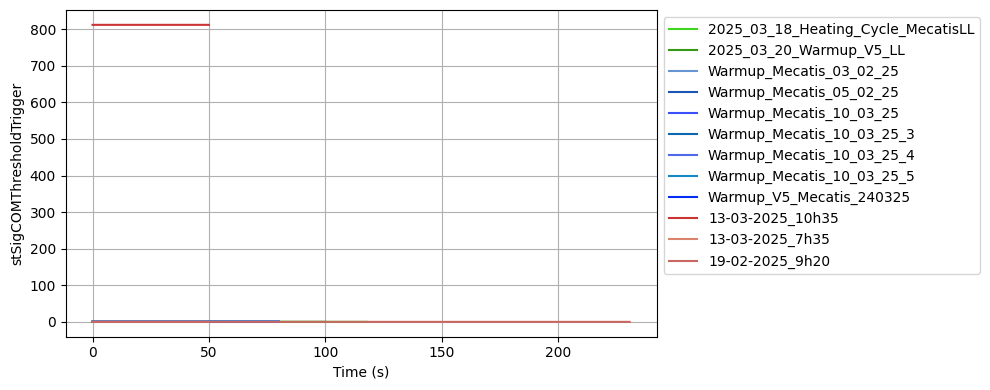

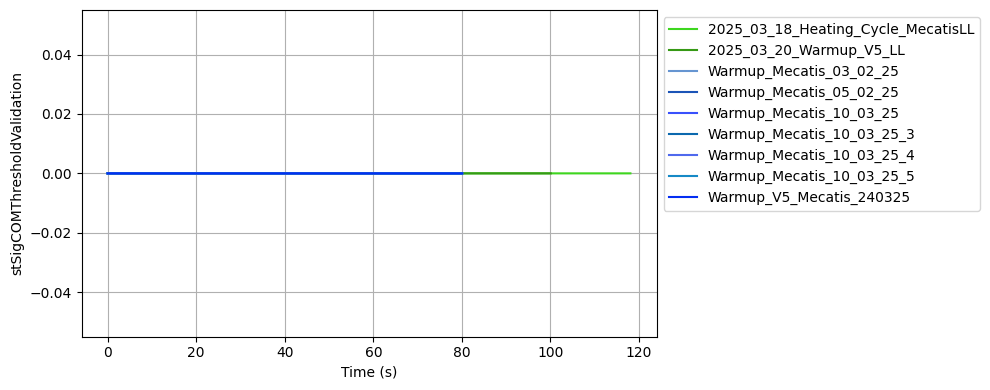

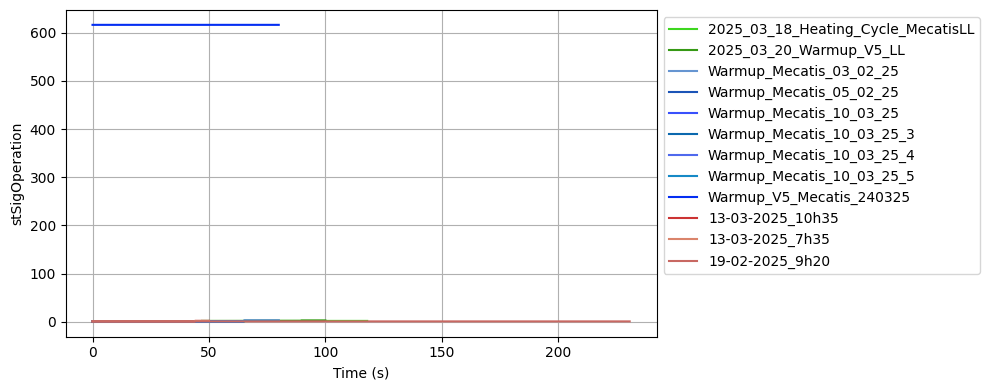

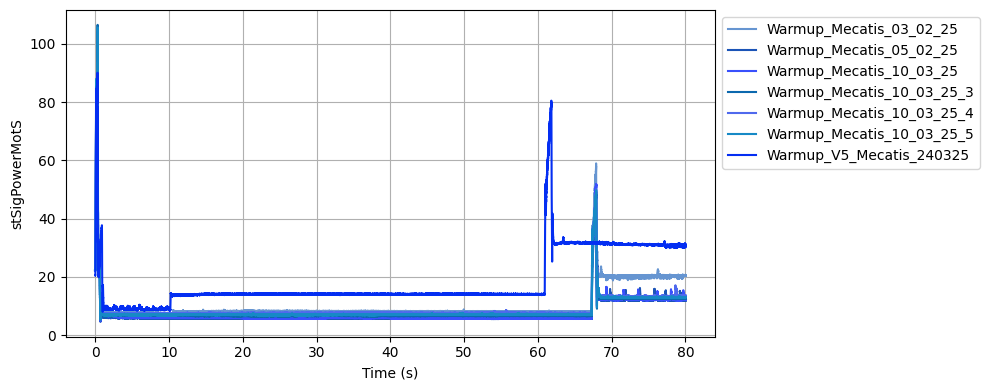

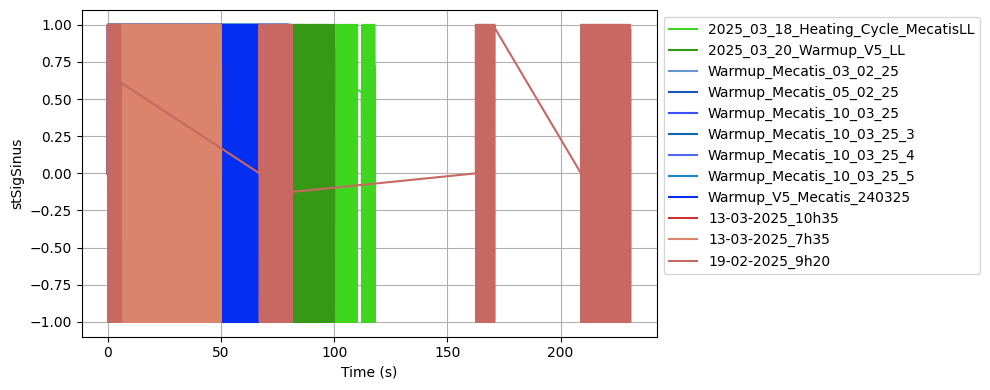

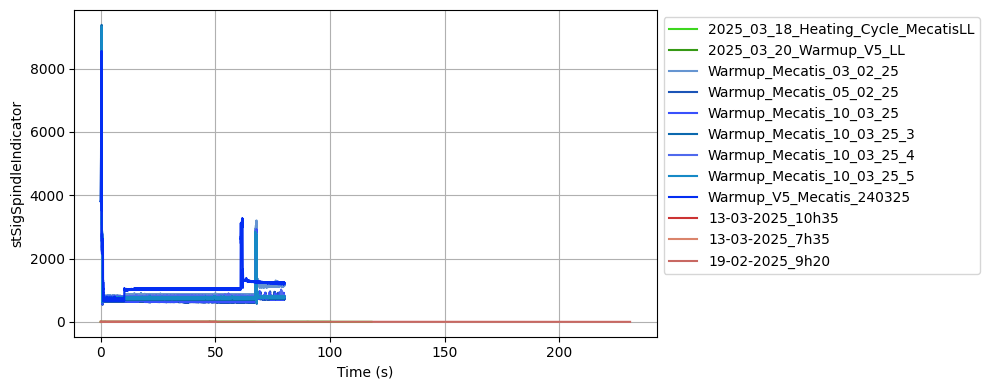

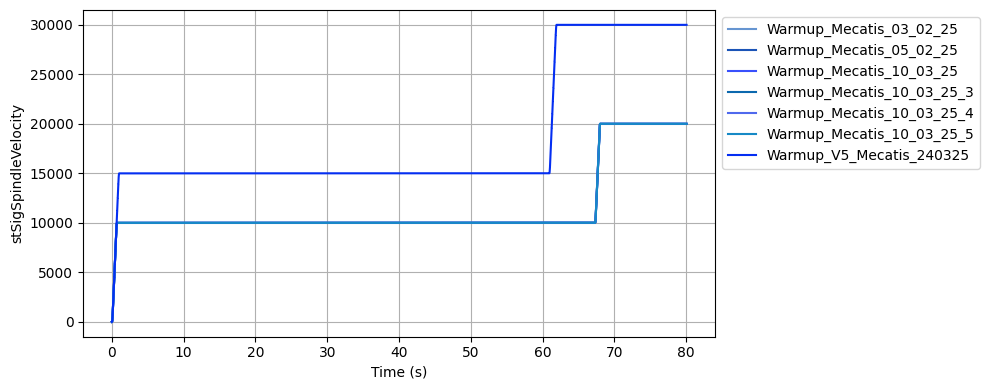

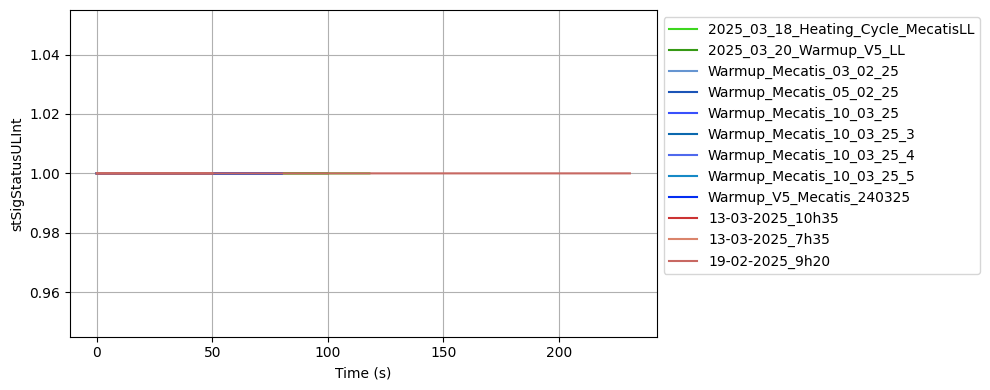

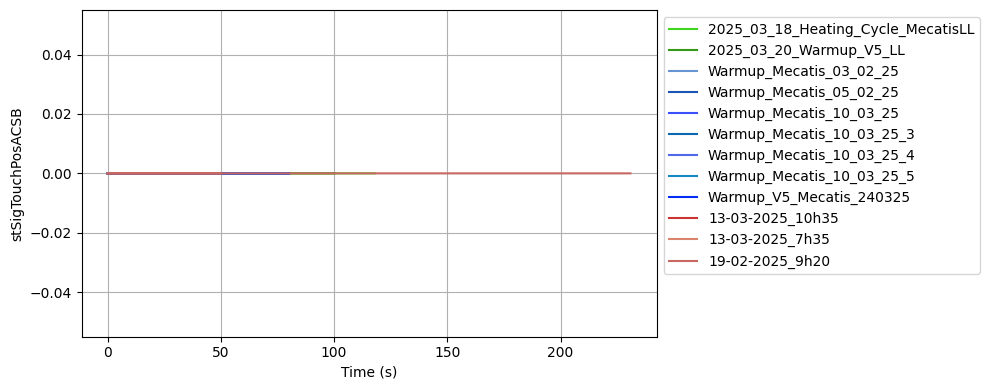

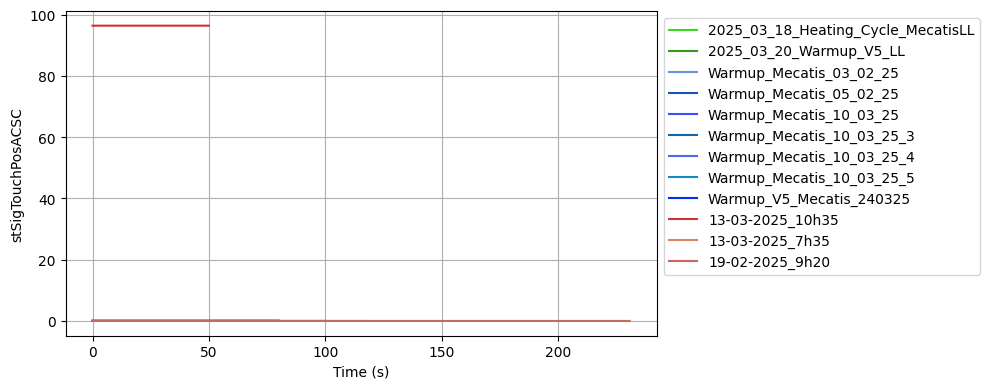

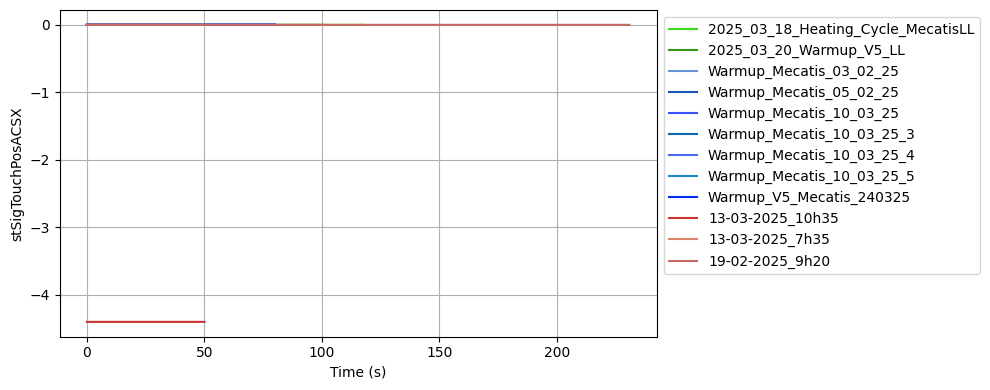

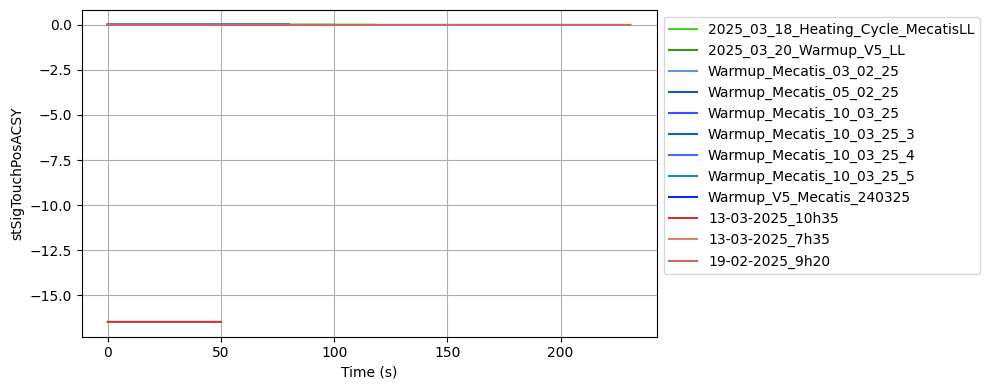

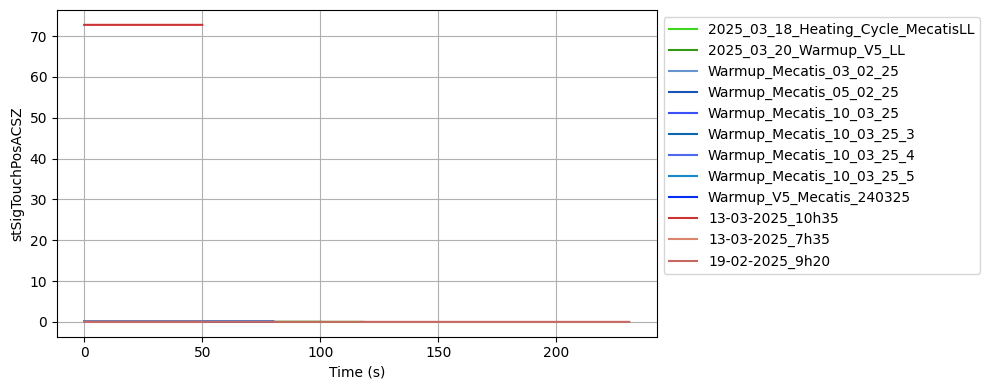

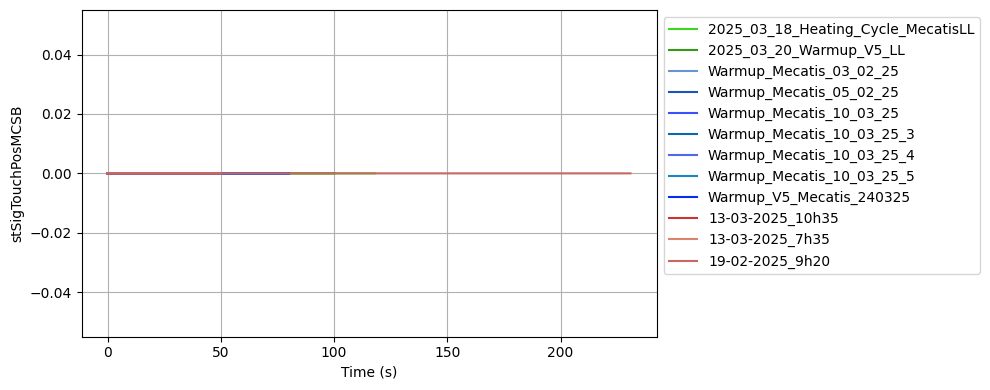

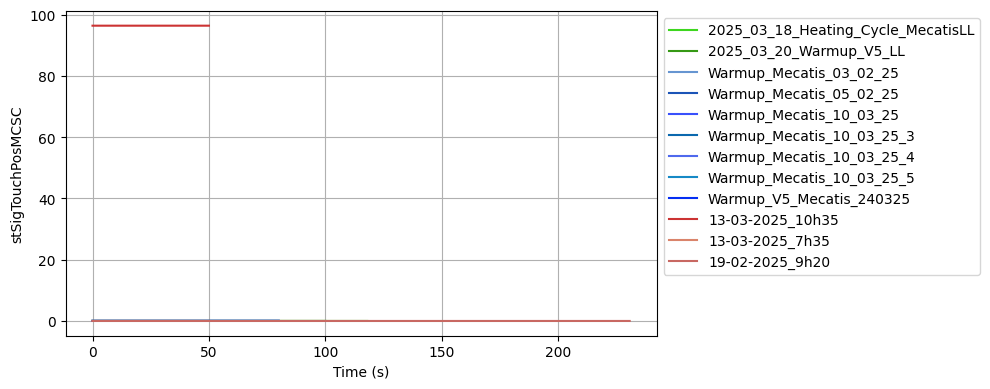

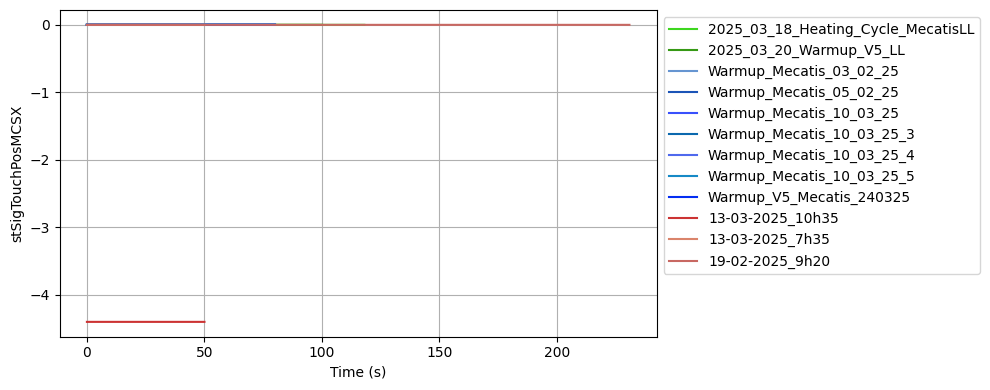

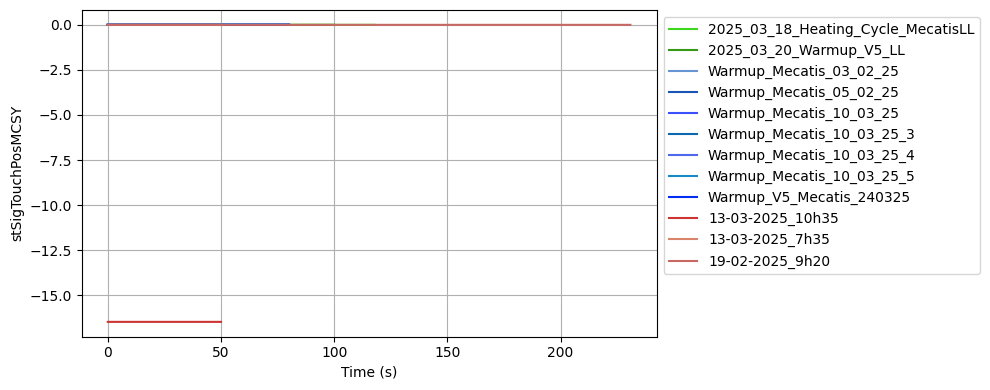

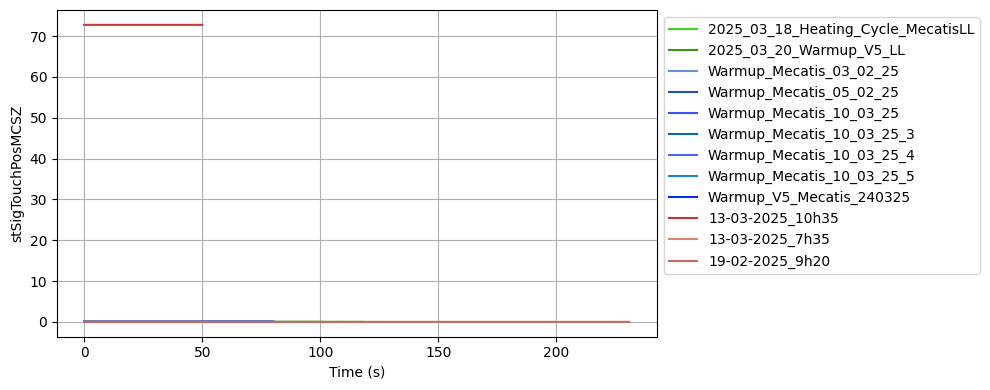

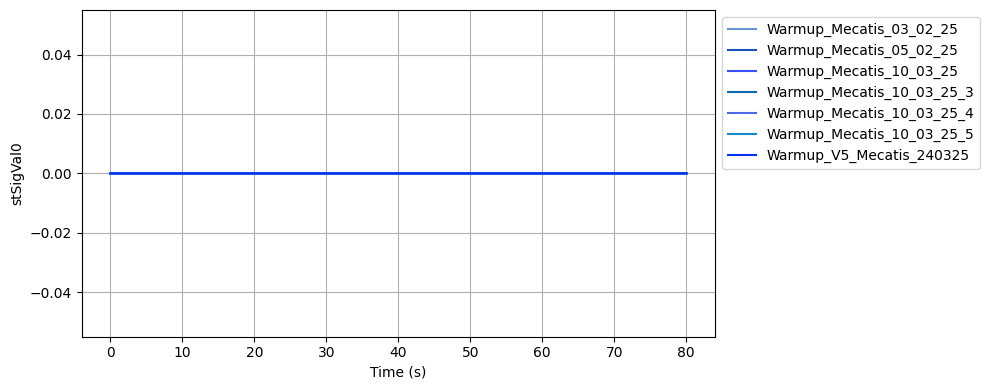

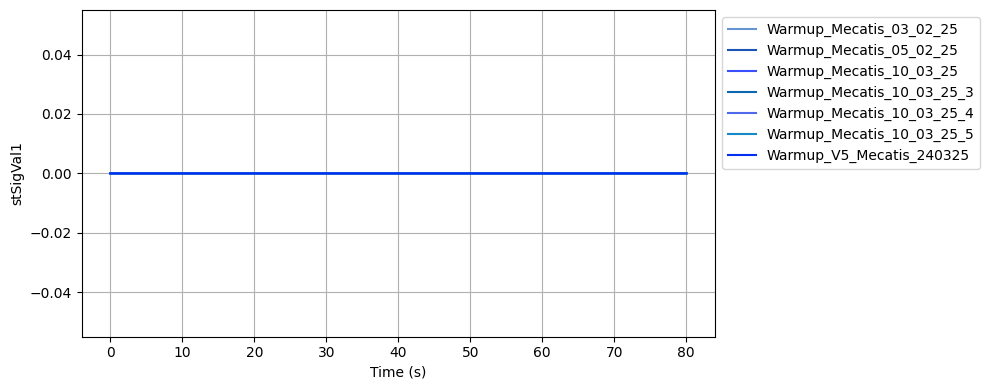

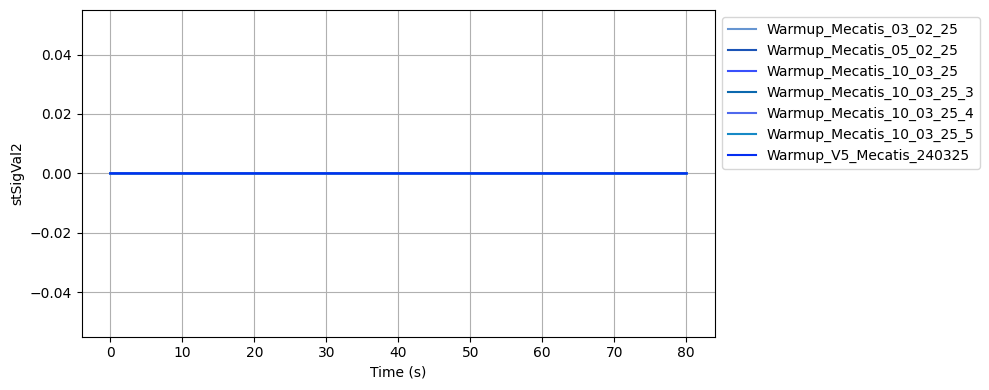

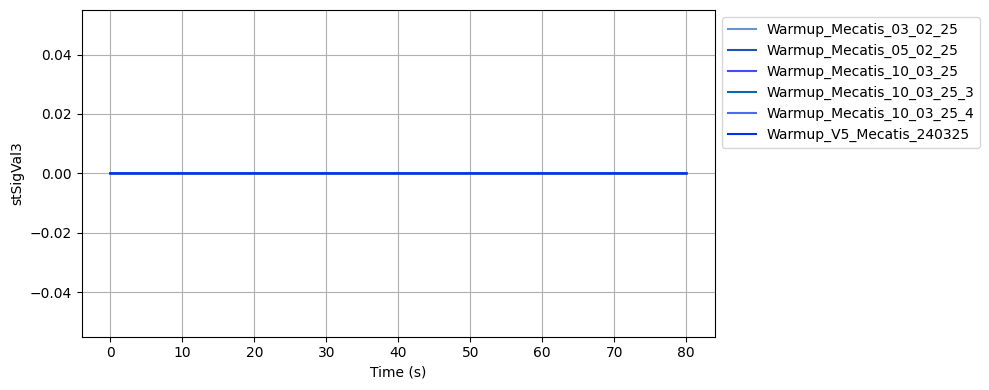

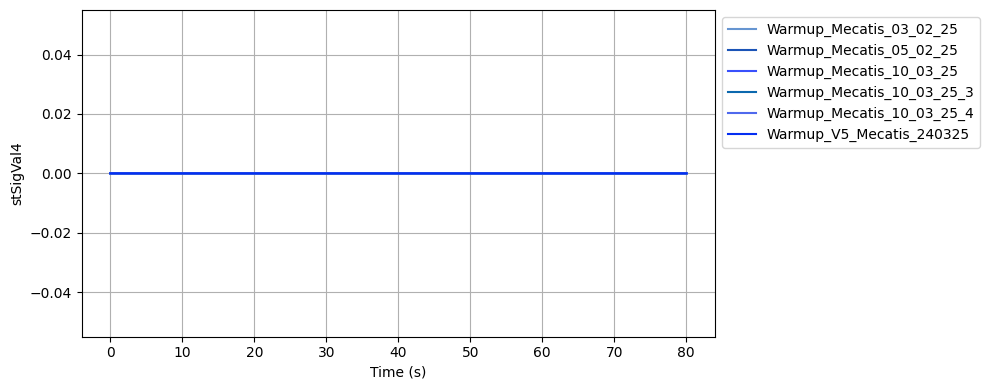

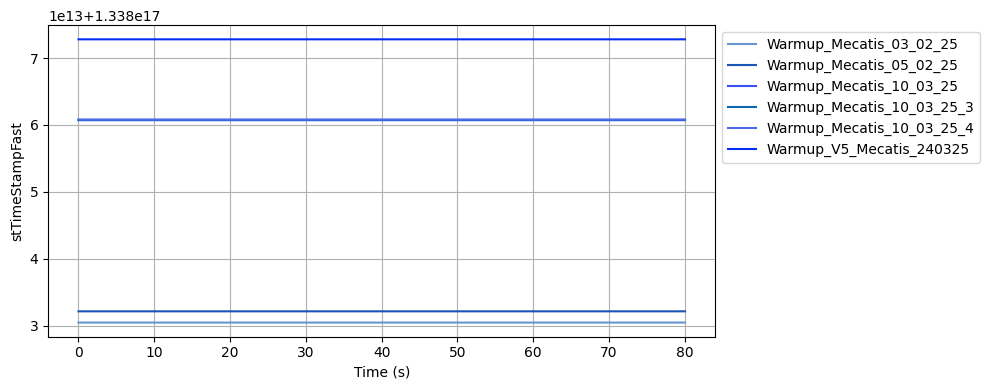

In [31]:
max_time_index = 100000
filtered_data = [data_prepared[1]] + [data_prepared[8]] 

for signal in signals :
    plot_signal(data_prepared, signal, max_time_index)